<h1>Required functions</h1>

In [1]:
#Visualize data output
import matplotlib.pyplot as plt
import matplotlib
import json
import statistics
import numpy as np

In [2]:
def set_font(size):
    text_font_size = size
    marker_font_size = size
    label_font_size = size
    axes_font_size = size

    plt.rc('text', usetex=True)
    plt.rc('pdf', use14corefonts=True, fonttype=42)
    plt.rc('ps', useafm=True)
    plt.rc('font', size=text_font_size, weight="bold", family='serif', serif='cm10')
    plt.rc('axes', labelsize=axes_font_size, labelweight="bold")    
    plt.rc('xtick', labelsize=label_font_size)    
    plt.rc('ytick', labelsize=label_font_size)    
    plt.rc('legend', fontsize=label_font_size)  
    
    # Use a single raw string for the LaTeX preamble
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\boldmath'

# Set the font size

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if data[i,j] != 0:
                text = im.axes.text(j, i, valfmt(data[i, j], None), fontsize=12,**kw)
            else:
                text = im.axes.text(j, i, "N.A", fontsize=12,**kw)
            texts.append(text)

    return texts

set_font(18)

In [3]:
QD = [2**i for i in range(10)]
PROCESS = [1,2,4,8]
WORKLOAD = ["randread","randwrite","read","write"]
MARKERS = [ "d", "^" , "X", "P","<",">","o","h","+"]
CALLS=0
BAR_COLOR = "springgreen"
CPU_COLOR = {
    'usr':"lightskyblue",
    'sys':"steelblue",
    'io':"black",
}

def save_plot(name):
    plt.savefig("./graphs/"+name+".png", bbox_inches = 'tight')

def plot_lat_percentile(experiment, name, percentile = 0,div=1, ax = None):
    if ax is None:
        ax = plt.gca()
    data = op[experiment]['latency']['percentile']
    data = {float(k): float(v) for k, v in data.items()}
    y = [i for i in data.keys() if i >= percentile]
    x = [data[i]/div for i in y]
    # Plot CDF
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    print(name, data)
    print("Percentage (95% - 50%): ", ((data[99.0] - data[50.0])/data[50.0])*100)
    ax.plot(x, y, '-'+mark,label=name)
    ax.grid(True)

def plot_lat_line(experiments, percentile, X, name, scale=1000):
    points = []
    for exp in experiments:
        if percentile is "max":
            data = op[exp]['latency']
        else:
            data = op[exp]['latency']['percentile']
            data = {float(k): float(v) for k, v in data.items()}
        points.append(data[percentile]/scale)
    print(name, percentile, points)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in X], points, '-'+mark, label=name)
    plt.grid(True)

def plot_99slat_line(experiments, X, name, scale=1000):
    points = []
    for exp in experiments:
        data = op[exp]['slat']['mean']
        std = op[exp]['slat']['stddev']
        points.append((data + (std*2.36))/scale)
    print(name, points)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in X],points,marker=mark,label=name)
    plt.grid(True)

def plot_99lat_bar(experiment, label):
    data = []
    for i in experiment:
        d = op[i]['latency']['percentile']
        d = {float(k): float(v)/10**3 for k, v in d.items()}
        y = d[99.00]
        data.append(y)
    print(data)
    plt.bar(np.arange(len(data)), data, label=label)#,color="lightskyblue"

    #plt.xlabel("Experiment")
    plt.ylabel(r'\textbf{p99 Latency($\mu$s)}')
    plt.grid(True)

def plot_lat_bar(experiment, name, ax, pos):
    data = op[experiment]['latency']['percentile']
    data = {float(k): float(v)/10**3 for k, v in data.items()}
    boxes = [
        {
            'label' : name,
            'whislo': data[5.00],    # Bottom whisker position
            'q1'    : data[20.0],    # First quartile (25th percentile)
            'med'   : data[50.0],    # Median         (50th percentile)
            'q3'    : data[80.0],    # Third quartile (75th percentile)
            'whishi': data[95.00],    # Top whisker position
            'fliers': []        # Outliers
        }
    ]
    print(boxes)
    ax.bxp(boxes,positions=[pos])
    plt.xlabel("Experiment")
    plt.ylabel('Latency(' + u"\u03bc"+ 'S)')
    plt.grid(True, 'both','y')

def plot_ctx_line(experiments,x,label):
    obs = []
    for exp in experiments:
        y = op[exp]['fio_cpu']['ctx']
        y = y / 1000
        obs.append(y)
    print(label, obs)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot(x,obs,'-'+mark,label=label)
    plt.grid(True)

def plot_net_line(experiments, key, x, label):
    obs = []
    for exp in experiments:
        y = op[exp][key]
        obs.append(y)
    print(label, obs)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot(x,obs,marker=mark,label=label)
    plt.grid(True)    

def plot_iops_line(experiments,x,label):
    obs = []
    err = []
    for exp in experiments:
        y = op[exp]['iops']['mean']
        y = y / 1000
        obs.append(y)
        err.append(op[exp]['iops']['stddev']/1000)
    print(label, obs, err)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    #plt.plot([str(i) for i in x],obs,'-'+mark,label=label)
    #print(err)
    plt.errorbar(x,obs,err,marker=mark,label=label)
    plt.grid(True)

def plot_iops_total(experiments,x,label):
    obs = []
    err = []
    for exp in experiments:
        y = op[exp]['iops']['total']
        y = y / 1000
        obs.append(y)
    print(label, obs, err)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],obs,'-'+mark,label=label)
    #print(err)
    #plt.errorbar(x,obs,err,marker=mark,label=label)
    plt.grid(True)

def plot_qos_iops_line(experiments,x,label):
    obs = []
    err = []
    for exp in experiments:
        y = op[exp]['iops']
        y = y / 1000
        obs.append(y)
    print(label, obs)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],obs,'-'+mark,label=label)
    #print(err)
    #plt.errorbar(x,obs,err,marker=mark,label=label)
    plt.grid(True)


def plot_iops_across_line(experiments,x,label):
    obs = []
    for exp in experiments:
        y = op[exp]['iops_across']
        y = y / 1000
        obs.append(y)
    print(label, obs)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],obs,'-'+mark,label=label)
    plt.grid(True)

def plot_iops_bar(experiments, name):
    data = []
    for experiment in experiments:
        y = op[experiment]['iops']['mean']
        y = y / 1000
        data.append(y)
        print(experiment,y)
    plt.bar(name,data)
    plt.ylabel('KIOPS')
    plt.grid(True)



def plot_iops_cpu(experiments):
    pass

def plot_bw_bar(experiment, label, offset):
    data = []
    for i in experiment:
        y = op[i]['bw']['mean']
        print(i, y)
        y = y/1000
        data.append(y)

    plt.bar(np.arange(len(data))+offset, data, width=0.3, label=label)#,color="lightskyblue"

    plt.xlabel("Experiment")
    plt.ylabel(r'\textbf{Bandwidth (MB/s)}')
    plt.grid(True)

def plot_bw_line(experiments,x,label):
    obs = []
    for exp in experiments:
        y = op[exp]['bw']
        y = y / (1024**2)
        obs.append(y)
    print(label, obs)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],obs,'-'+mark,label=label)
    plt.ylabel("GB/s")
    plt.grid(True)

def plot_run_time(experiments, x, label):
    results = []
    for i in experiments:
        usr = op[i]['cpu']['usr']
        sys = op[i]['cpu']['sys']
        runtime = op[i]['cpu']['total'] / 1000
        results.append(usr*runtime + sys*runtime)
    print(label, results)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],results, "-"+mark,label=label)
    plt.grid()

def plot_cpu(experiments, x, label):
    results = []
    for i in experiments:
        usr = op[i]['cpu']['usr']
        sys = op[i]['cpu']['sys']
        results.append(usr+sys)
    print(label, results)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],results, "-"+mark,label=label)
    plt.grid()


def plot_init_rp_time(experiments, x, label):
    results = []
    for i in experiments:
        print(i)
        results.append(op[i]['initiator']['reqprocessing'])
    print(label, results)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],results, "-"+mark,label=label)
    plt.grid()

def plot_target_blk_time(experiments, x, label):
    results = []
    for i in experiments:
        results.append(op[i]['target']['blk'])
    print(label, results)
    global CALLS
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot([str(i) for i in x],results, "-"+mark,label=label)
    plt.grid()

def cpu_utilization(experiment, name):
    cpu = op[experiment]['cpu']
    print(experiment, cpu)
    bottom=0
    for i in ['usr','sys']:
        plt.bar([name], [cpu[i]],color=CPU_COLOR[i],bottom=bottom, label=i)
        bottom += cpu[i]
    plt.xlabel("Experiment")
    plt.ylabel('CPU utilization')
    plt.grid(True)

def cpu_init_utilization(experiment, name, plot_cpu):
    cpu = op[experiment]['init_cpu']
    print(experiment, cpu)

    if plot_cpu == -1:
        plot_cpu="all"
    else:
        plot_cpu = str(plot_cpu)

    bottom=0
    for i in ['usr','sys','io']:
        plt.bar([name], [float(cpu[plot_cpu][i])],color=CPU_COLOR[i],bottom=bottom, label=i)
        bottom += float(cpu[plot_cpu][i])
    
    print("CPU util : ", bottom - float(cpu[plot_cpu][i]))
    plt.xlabel("Experiment")
    plt.ylabel('CPU utilization')
    plt.grid(True)

def cpu_local_utilization(experiment, name, plot_cpu):
    cpu = op[experiment]['local_cpu']
    print(experiment, cpu)

    if plot_cpu == -1:
        plot_cpu="all"
    else:
        plot_cpu = str(plot_cpu)

    bottom=0
    for i in ['usr','sys','io']:
        plt.bar([name], [float(cpu[plot_cpu][i])],color=CPU_COLOR[i],bottom=bottom, label=i)
        bottom += float(cpu[plot_cpu][i])
    plt.xlabel("Experiment")
    plt.ylabel('CPU utilization')
    plt.grid(True)

def cpu_target_utilization(experiment, name):
    cpu = op[experiment]['target_cpu']
    print(experiment, cpu)
    bottom=0
    plot_cpu = 'all'
    plot_cpu_util = 0
    for i in cpu.keys():
        if i != 'all':
            util = float(cpu[i]['sys'])
            if util > plot_cpu_util:
                plot_cpu = i
                plot_cpu_util = util

    for i in ['sys']:
        plt.bar([name], [float(cpu[plot_cpu][i])], color=CPU_COLOR[i], bottom=bottom, label=i)
        bottom += float(cpu[plot_cpu][i])
        
    plt.xlabel("Experiment")
    plt.ylabel('CPU utilization')
    plt.grid(True)

def plot_iops_ts(file, name, lim=-1):
    try:
        f = open(file,'r')
    except:
        return
    
    numbers = []
    obs = []
    prev_ts = 0
    for i in f.readlines():
        try:
            ts = int(i.split(",")[0])
            if prev_ts > ts:
                numbers = []
                obs.append(numbers)
            prev_ts = ts
            numbers.append(int(i.split(",")[1])/1000)
        except:
            pass
    obs.append(numbers)
    obs = [sum(i) for i in zip(*obs)]
    plt.plot(obs[:lim],label=name)
    print(name, statistics.median(obs), statistics.mean(obs))
    #plt.axhline(y=statistics.median(obs), linestyle='dashed')
    #plt.axhline(y=statistics.mean(obs), linestyle='dotted')

def plot_lat_iops(experiments, percentile, names):
    dic = {}
    for exp,name in zip(experiments, names):
        iops = op[exp]['iops']['mean']
        data = op[exp]['latency']['percentile']
        data = {float(k): float(v) for k, v in data.items()}
        dic[name] = [data[percentile]/1000, iops/1000]
    return dic


def microbench(data, toplot, percentile, plot_key, plot_target = True):
    block = data[toplot][str(percentile)]["block"]
    nvmeof_init = data[toplot][str(percentile)]["nvmeof_initiator"]
    tcp = data[toplot][str(percentile)]["tcp"]
    target = data[toplot][str(percentile)]["target"]
    print(data[toplot][str(percentile)])
    bar_width = 0.4
    plt.bar(plot_key, block, bar_width, label='Block')
    plt.bar(plot_key, nvmeof_init, bar_width, bottom=block, label='NVMeOF Initiator')
    plt.bar(plot_key, tcp, bar_width, bottom=block + nvmeof_init, label='TCP')
    if plot_target:
        plt.bar(plot_key, target, bar_width, bottom=block + nvmeof_init + tcp, label='Target')



<>:35: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:35: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipykernel_3420200/2617857203.py:35: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if percentile is "max":


<h1>Performance</h1>

In [4]:
fp = open("./performance/crunched_numbers_performance.json")
op = json.load(fp)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
for j in [1,2,4,8,10]: #,"npoll_ioup","poll_ioup"
    experiments=[]
    for i in ["1qp","2qp","3qp","4qp","5qp","6qp","7qp","8qp","9qp","10qp","11qp"]: #,
        experiments.append("remote_{}_npoll_ioup_SSD_randread_QD128_P{}_4k".format(i, j))
    plot_iops_line(experiments, [i for i in range(1,12)], "{}P".format(j))

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('IOPS for different number of queue pairs (random read on NVMeoF-TCP)')
plt.xlabel(r"\textbf{\# Queue pairs}")
plt.ylabel(r'\textbf{Throughput (KIOPS)}')
#plt.xticks([1,2,4,8,10,12])
plt.ylim(bottom=0)
plt.legend(title=r"\textbf{\# Process}")
save_plot("nqp_iops")

In [92]:
%%skip
fp = open("./performance/crunched_numbers_performance.json")
op = json.load(fp)
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
for j in [1,2,4,8,10]: #,"npoll_ioup","poll_ioup"
    experiments=[]
    for i in ["1qp","2qp","3qp","4qp","5qp","6qp","7qp","8qp","9qp","10qp","11qp"]: #,
        experiments.append("remote_{}_npoll_ioup_SSD_randread_QD128_P{}_4k".format(i, j))
    plot_lat_line(experiments, 99,[i for i in range(1,12)], "{}P".format(j))

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('p95 latency for different number of queue pairs (random read on NVMeoF-TCP)')
plt.xlabel(r"\textbf{\# Queue pairs}")
plt.ylabel(r'\textbf{Latency ($\mu$S)}')
plt.ylim(bottom=0)
save_plot("nqp_lat")
#plt.legend()

UsageError: Cell magic `%%skip` not found.


\textbf{Polling block layer} [10.562778243, 19.729529167, 28.224158333, 40.294895833000005, 57.006995833, 80.37322916699999, 83.677879167, 114.22189166700001, 110.456408333] [0.11725282, 0.398194218, 1.0899361120000002, 2.312570819, 3.408967225, 6.005380468, 6.056151056, 3.2799491929999998, 3.1155446619999996]
\textbf{Polling NVMeoF-TCP layer} [11.57105, 21.802729167000003, 30.817241666999998, 47.083246862, 68.820208333, 97.78124166699999, 124.942828452, 130.73256666700001, 109.423916667] [0.089977668, 0.702981848, 1.06714362, 2.658223112, 3.63357904, 5.084373611, 3.568758276, 1.311868409, 3.7660405810000004]


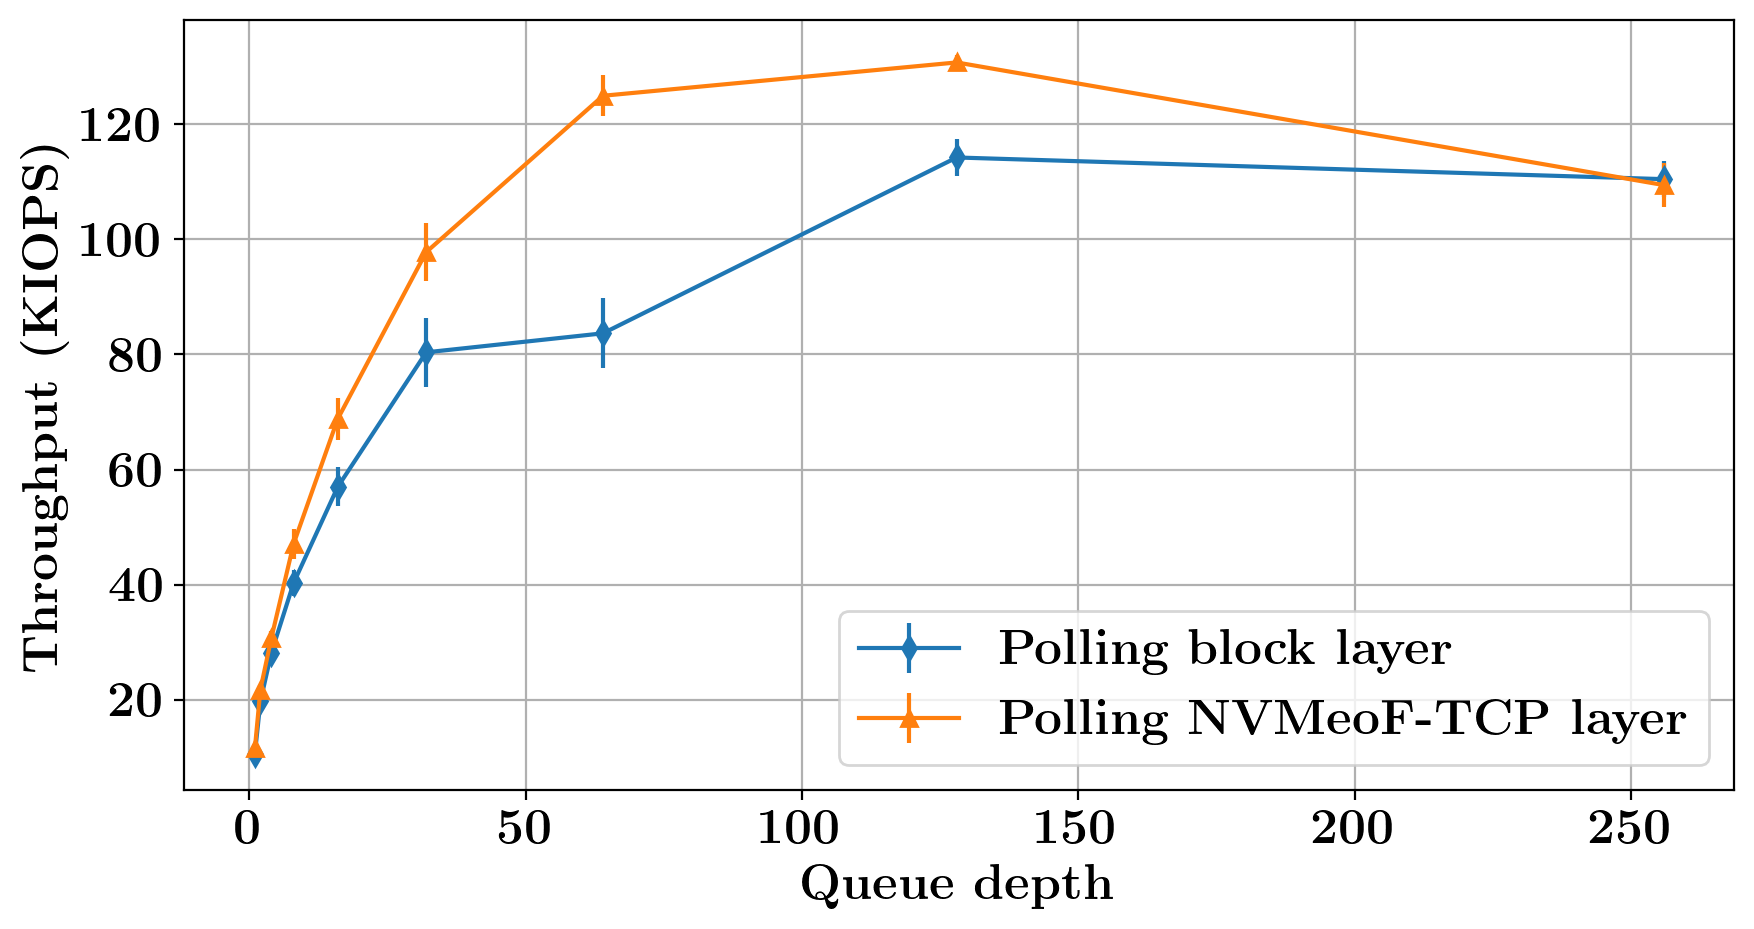

In [5]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
#labels = ["No polling","Polling block","Polling NVMeoF-TCP"]
#for en, j in enumerate(["perf_npoll_iou","perf_npoll_ioup","perf_poll_ioup"]):
labels = [r"\textbf{Polling block layer}",r"\textbf{Polling NVMeoF-TCP layer}"]
for en, j in enumerate(["perf_npoll_ioup","perf_poll_ioup"]):
    experiments=[]
    for i in [1, 2, 4, 8, 16 ,32, 64, 128, 256]:
        experiments.append("remote_{}_SSD_randread_QD{}_P1_4k".format(j, i))
    plot_iops_line(experiments, [1, 2, 4, 8, 16 ,32, 64, 128, 256], labels[en])

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('Context switch count for different completion semantics (random read on NVMeoF-TCP)')
plt.xlabel(r"\textbf{Queue depth}")
plt.ylabel(r"\textbf{Throughput (KIOPS)}")
plt.legend()
save_plot("pollnpoll_iops")

[127.488, 115.2]


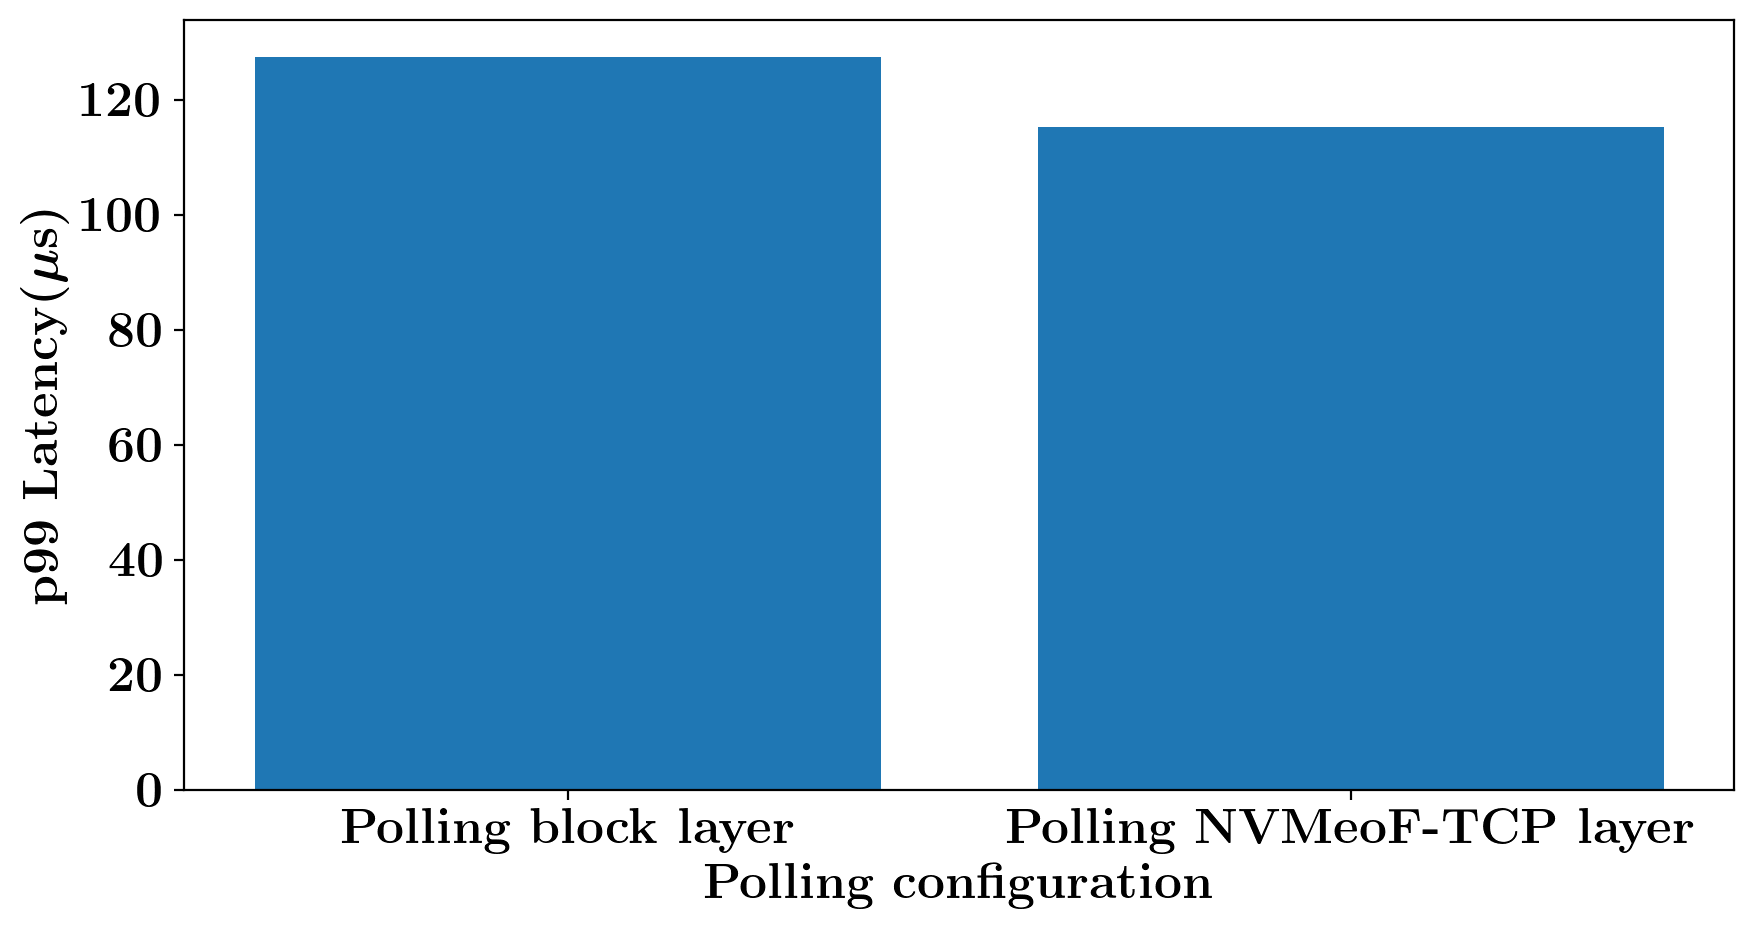

In [7]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
#labels = ["No polling","Polling block","Polling NVMeoF-TCP"]
#for en, j in enumerate(["perf_npoll_iou","perf_npoll_ioup","perf_poll_ioup"]):
labels = [r"\textbf{Polling block layer}",r"\textbf{Polling NVMeoF-TCP layer}"]
experiments = []
for en, j in enumerate(["perf_npoll_ioup","perf_poll_ioup"]):
    experiments.append("remote_{}_SSD_randread_QD1_P1_4k".format(j))
plot_99lat_bar(experiments, "")
#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('p95 latency for different target polling (random read on NVMeoF-TCP)')
plt.xticks([i for i in range(2)], labels)
plt.grid(False)
plt.xlabel(r"\textbf{Polling configuration}")
#plt.yticks([i for i in range(0,300,10)])
save_plot("pollnpoll_lat")

\textbf{Polling block layer} [1292.504, 2241.944, 2741.329, 2933.966, 3063.889, 3044.975, 1829.804, 1379.483, 2668.501]
\textbf{Polling NVMeoF-TCP layer} [57.481, 31.189, 30.106, 20.324, 28.26, 89.914, 296.69, 411.435, 2682.795]


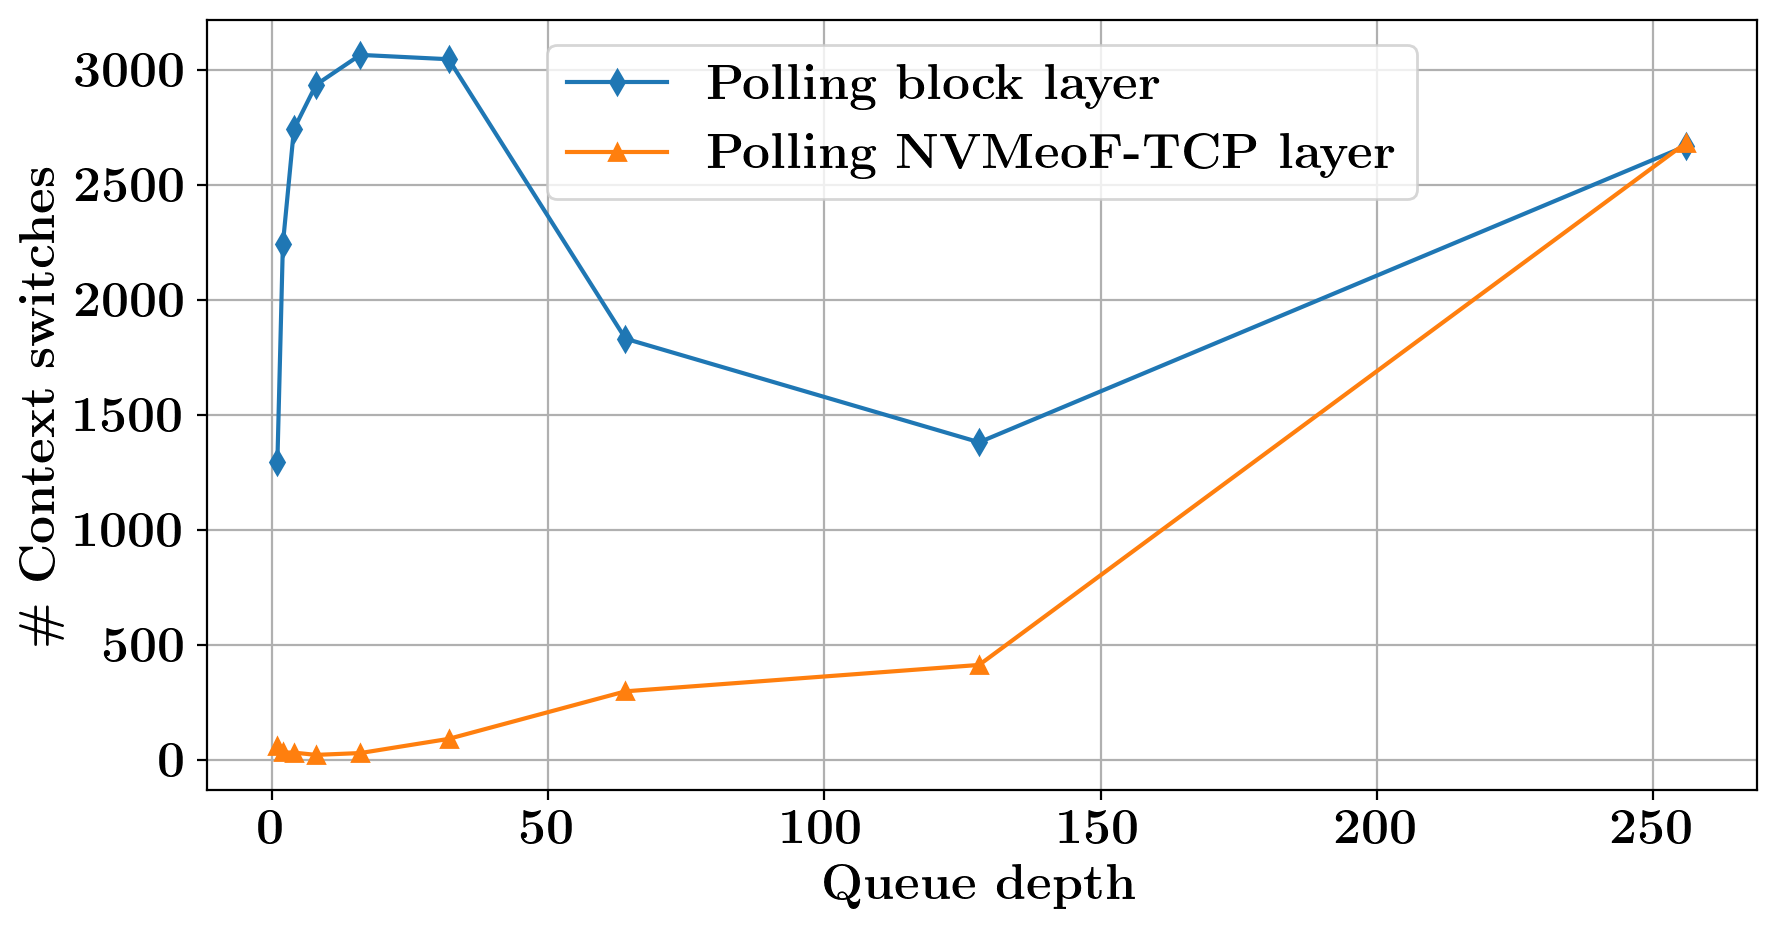

In [95]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
#labels = ["No polling","Polling block","Polling NVMeoF-TCP"]
#for en, j in enumerate(["perf_npoll_iou","perf_npoll_ioup","perf_poll_ioup"]):
labels = [r"\textbf{Polling block layer}",r"\textbf{Polling NVMeoF-TCP layer}"]
for en, j in enumerate(["perf_npoll_ioup","perf_poll_ioup"]):
    experiments=[]
    for i in [1, 2, 4, 8, 16 ,32, 64, 128, 256]:
        experiments.append("remote_{}_SSD_randread_QD{}_P1_4k".format(j, i))
    plot_ctx_line(experiments, [1, 2, 4, 8, 16 ,32, 64, 128, 256], labels[en])

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('Context switch count for different completion semantics (random read on NVMeoF-TCP)')
plt.xlabel(r"\textbf{Queue depth}")
plt.ylabel(r"\textbf{\# Context switches}")
plt.legend()
save_plot("pollnpoll_ctx")

perf_woarfs_npoll_iou [114.198641667] [4.389049630000001]
perf_arfs_npoll_iou [118.7993] [1.4957394979999998]
perf_woarfs_ioup [124.432120833] [1.3378081549999998]
perf_arfs_ioup [121.485395833] [1.2706626900000002]


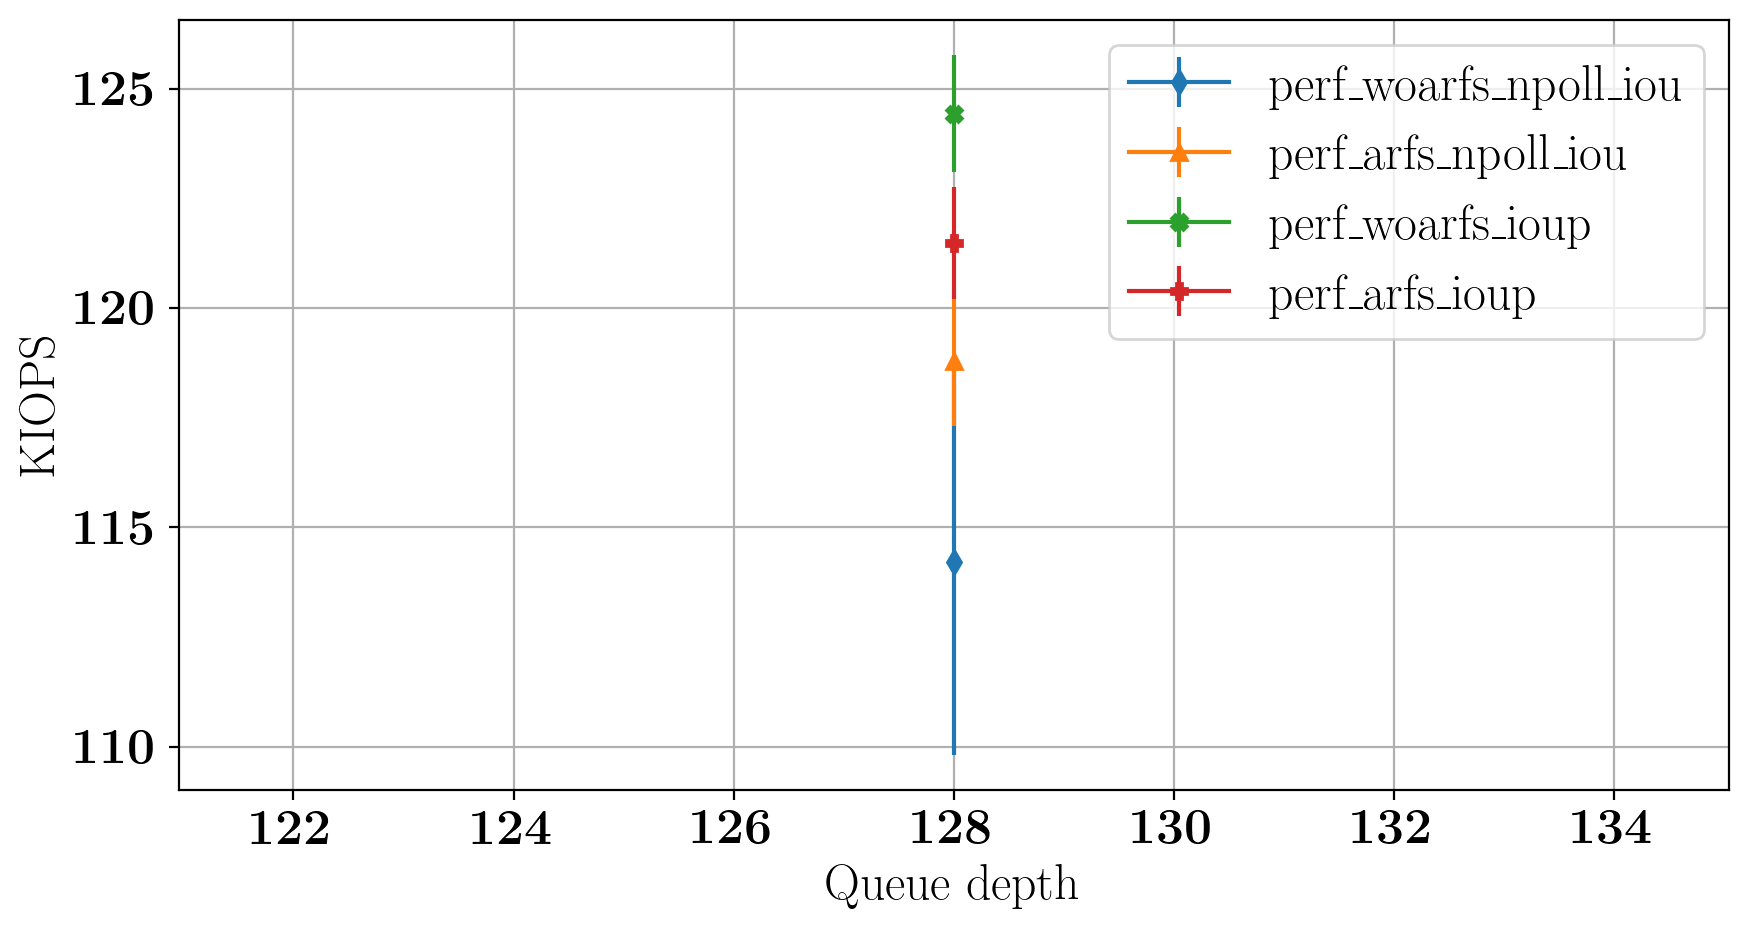

In [15]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
labels = ["Without interrupt affinity", "With interrupt affinity"]
for en, j in enumerate(["perf_woarfs_npoll_iou","perf_arfs_npoll_iou","perf_woarfs_ioup","perf_arfs_ioup"]):
    experiments=[]
    for i in [128]:
        experiments.append("remote_{}_SSD_randread_QD{}_P1_4k".format(j, i))
    plot_iops_line(experiments, [128], j)

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('P95 latency for different QD (random read on NVMeoF-TCP)')
plt.xlabel("Queue depth")
plt.ylabel('KIOPS')
plt.grid(True)
plt.legend()

[124.416, 121.344, 110.08, 105.984]


Text(0.5, 0, 'Interrupt affinity and polling')

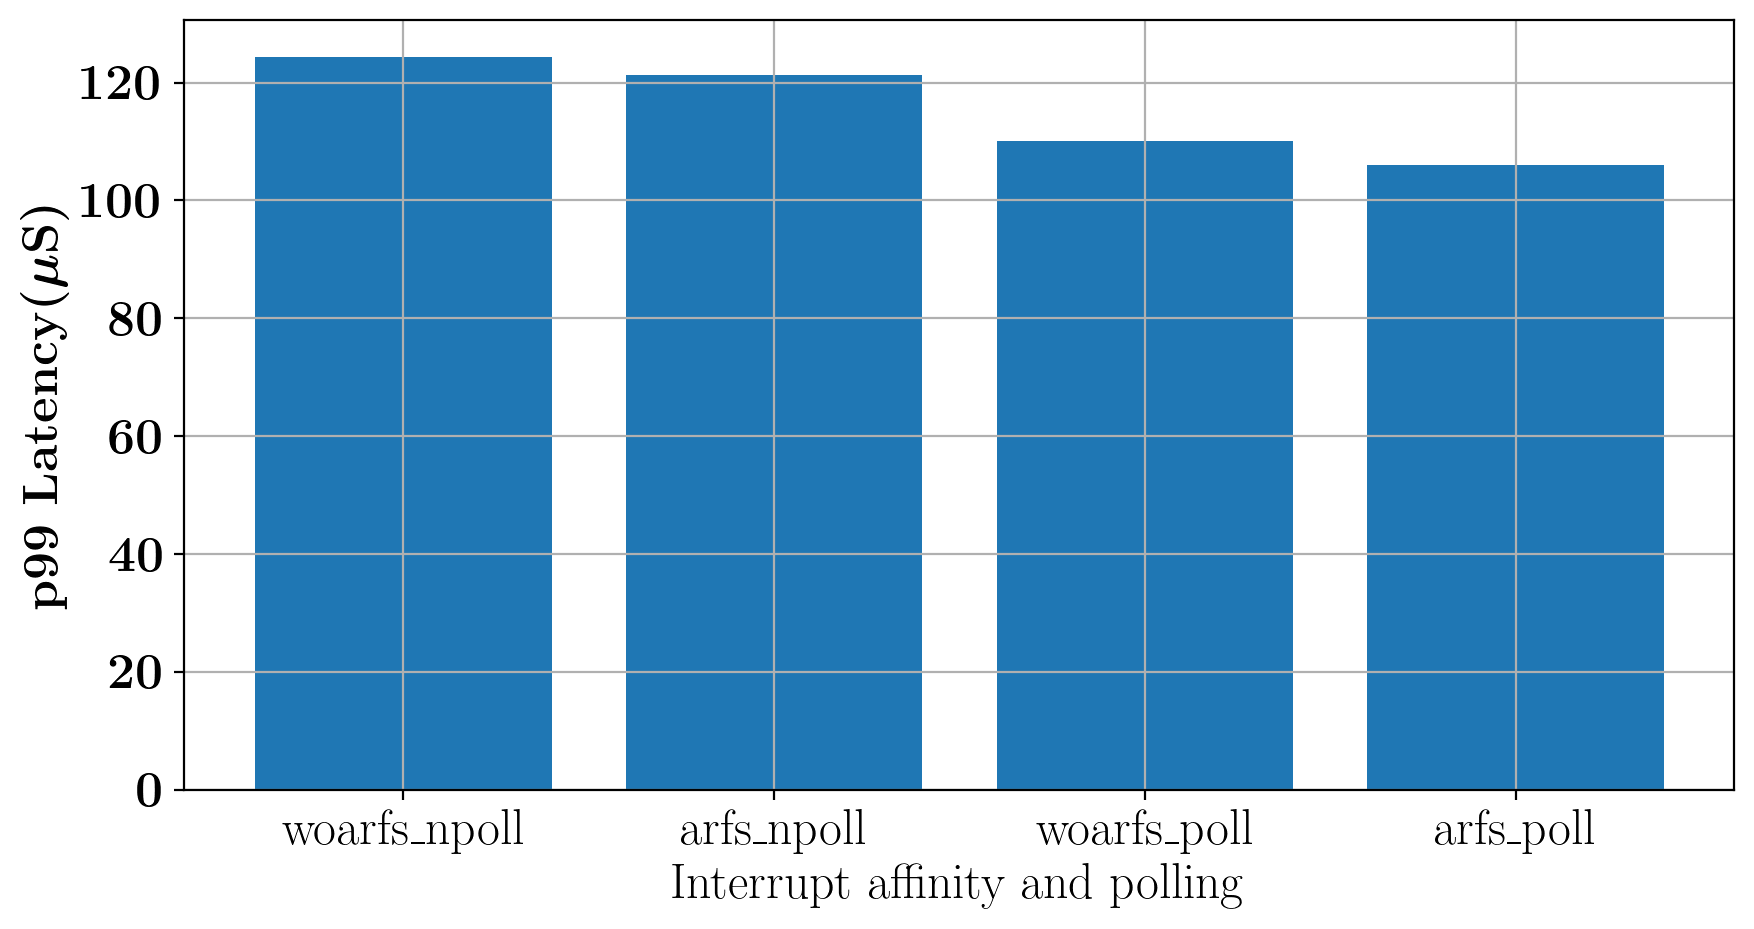

In [19]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
labels = ["woarfs_npoll", "arfs_npoll","woarfs_poll","arfs_poll"]
experiments = []
for en, j in enumerate(["perf_woarfs_npoll_iou","perf_arfs_npoll_iou","perf_woarfs_ioup","perf_arfs_ioup"]):
    experiments.append("remote_{}_SSD_randread_QD1_P1_4k".format(j))
plot_99lat_bar(experiments, "")
#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('p95 latency for different target polling (random read on NVMeoF-TCP)')
plt.xticks([i for i in range(4)], labels)
plt.xlabel('Interrupt affinity and polling')
#plt.yticks([i for i in range(0,300,10)])

[116.224, 103.936, 104.96, 104.96, 104.96, 104.96]


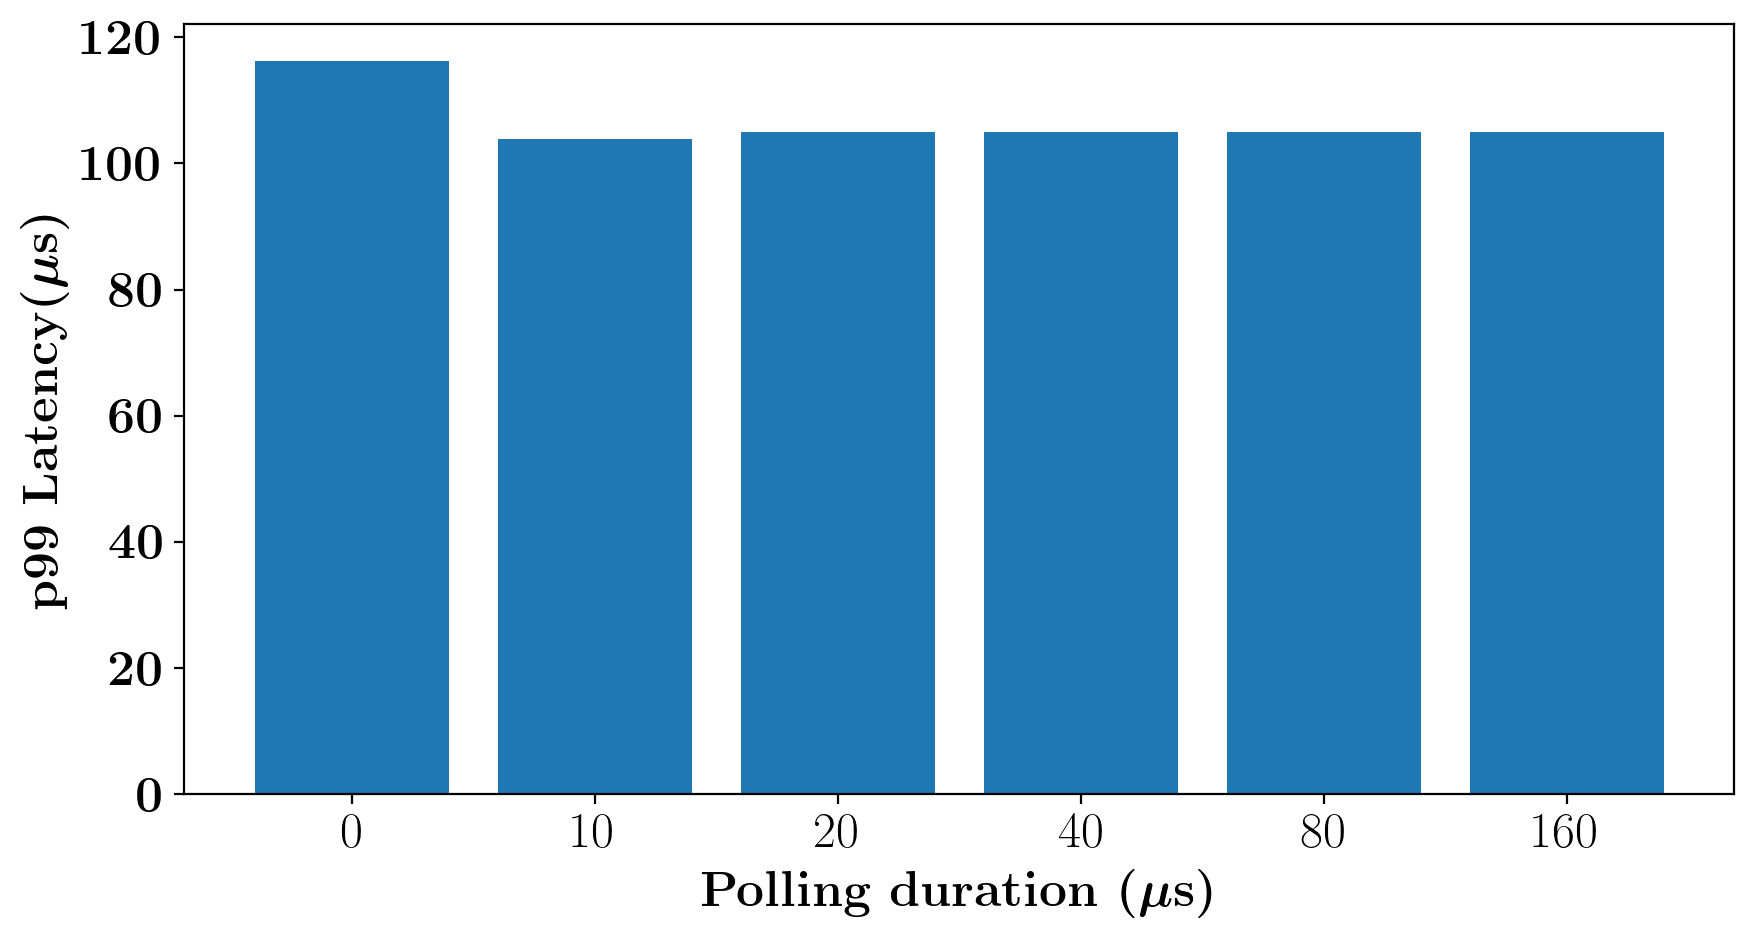

In [10]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
experiments=[]
for j in [0, 10, 20, 40, 80, 160]:
    experiments.append("remote_tpoll{}_ioup_SSD_randread_QD1_P1_4k".format(j))
plot_99lat_bar(experiments, "")
#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('p95 latency for different target polling (random read on NVMeoF-TCP)')
plt.xticks([i for i in range(6)], [0, 10, 20, 40, 80, 160])
plt.xlabel(r'\textbf{Polling duration ($\mu$s)}')
plt.grid(False)
save_plot("tpoll_lat")
#plt.yticks([i for i in range(0,300,10)])


0 [10.938941667, 21.006091667, 31.6580875, 51.1574375, 80.0133125, 107.399079167, 126.5099625, 129.397929167, 115.054341667] [0.319353604, 0.56496556, 0.991111487, 0.8046679840000001, 2.5338799770000002, 4.533568132, 0.9114903849999999, 1.1774638259999999, 2.3029083740000003]
10 [12.678608333, 24.1775875, 35.163058333, 54.928183333, 83.225033333, 108.1544625, 127.80754583299999, 126.312625, 120.68177499999999] [0.421296123, 0.964870642, 1.549396399, 0.875984844, 4.240825661, 1.8490727059999998, 1.020488995, 1.619724748, 2.03977999]
20 [12.6521375, 24.235535565, 34.973662499999996, 55.033941667, 84.23549583299999, 109.084604167, 125.411504167, 125.341908333, 119.509025] [0.417166866, 0.816727353, 1.527749136, 0.9876215610000001, 3.05428827, 3.2715185339999997, 1.31414236, 0.898321643, 2.262243634]
40 [12.637991667, 24.327008333000002, 35.287875, 55.117875, 83.793758333, 108.50167916699999, 126.198075, 126.5960875, 120.021833333] [0.40302650999999995, 0.693336865, 1.60249558, 1.161450497

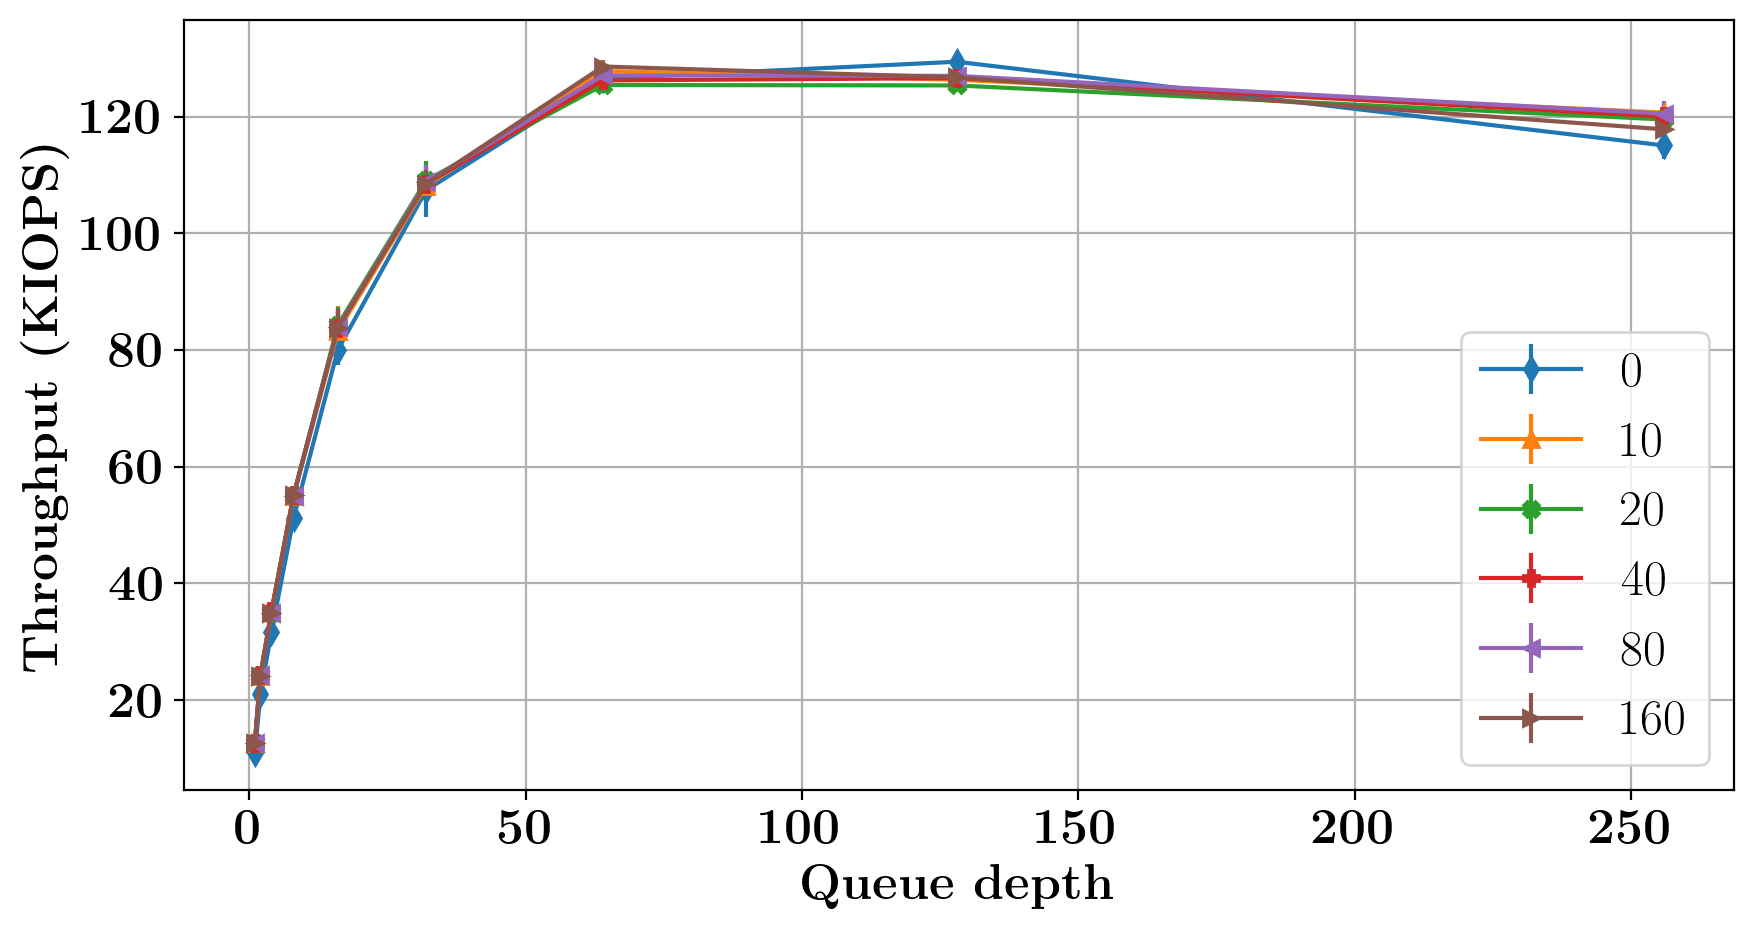

In [8]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
#labels = ["No polling","Polling block","Polling NVMeoF-TCP"]
#for en, j in enumerate(["perf_npoll_iou","perf_npoll_ioup","perf_poll_ioup"]):
labels = [r"\textbf{10}",r"\textbf{NVMeoF-TCP}"]
for en, j in enumerate([0, 10, 20, 40, 80, 160]):
    experiments=[]
    for i in [1, 2, 4, 8, 16 ,32, 64, 128, 256]:
        experiments.append("remote_tpoll{}_ioup_SSD_randread_QD{}_P1_4k".format(j, i))
    plot_iops_line(experiments, [1, 2, 4, 8, 16 ,32, 64, 128, 256], j)

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('Context switch count for different completion semantics (random read on NVMeoF-TCP)')
plt.xlabel(r"\textbf{Queue depth}")
plt.ylabel(r"\textbf{Throughput (KIOPS)}")
plt.legend()
#plt.annotate(r'\textbf{QD128}', xy =(128,128.24), xytext =(50, 50),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
#plt.annotate(r'\textbf{QD256}', xy =(256,332.68), xytext =(200, 250),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
#save_plot("local_remote_iops")

<h1>RQ2</h1>

[82.432, 88.576, 104.96]


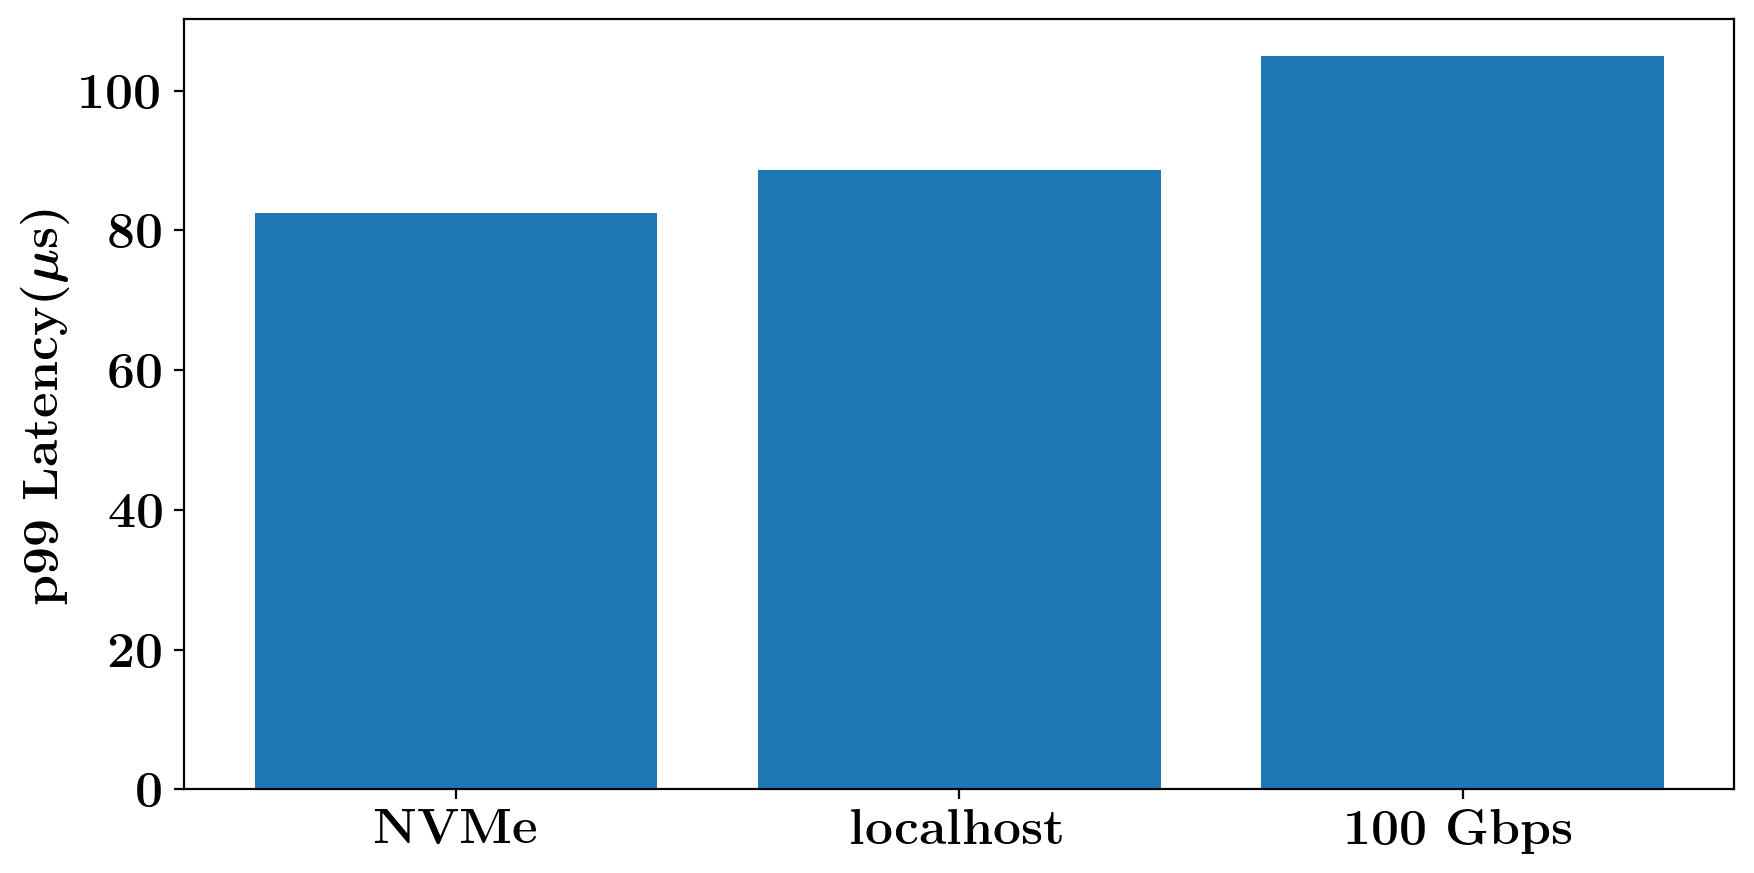

In [11]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
labels = [r"\textbf{NVMe}", r"\textbf{localhost}",r"\textbf{100 Gbps}"]
experiments = ["local_bench_ioup_SSD_randread_QD1_P1_4k", "localtcp_bench_npoll_iou_SSD_randread_QD1_P1_4k", "remote_bench_ioup_SSD_randread_QD1_P1_4k"]
plot_99lat_bar(experiments, "")
#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('p95 latency for different target polling (random read on NVMeoF-TCP)')
plt.xticks([i for i in range(3)], labels)
plt.grid(False)
plt.xlabel('')
save_plot("local_remote_lat")
#plt.yticks([i for i in range(0,300,10)])


\textbf{NVMe} [19.533475, 37.516958333000005, 47.994866667000004, 63.339504167, 95.59875416700001, 139.59322500000002, 193.939804167, 287.81045416700005, 332.6887375, 328.96695833300004, 320.34625] [0.09392447400000001, 1.2434883440000002, 2.961441384, 4.009981821, 6.224124694, 19.311882988, 35.482981677999994, 13.404459704999999, 2.063179875, 1.130566562, 1.3021796159999999]
\textbf{NVMeoF-TCP} [13.049175, 25.6144125, 35.414104167, 51.686820833, 73.78762083299999, 97.136575, 123.597420833, 128.243833333, 117.427125, 115.43803333299999, 112.200370833] [0.509420052, 0.758414306, 1.671864435, 3.632957441, 6.16312735, 7.304365318, 3.658040391, 1.115286652, 3.30837229, 2.975292932, 3.096273757]


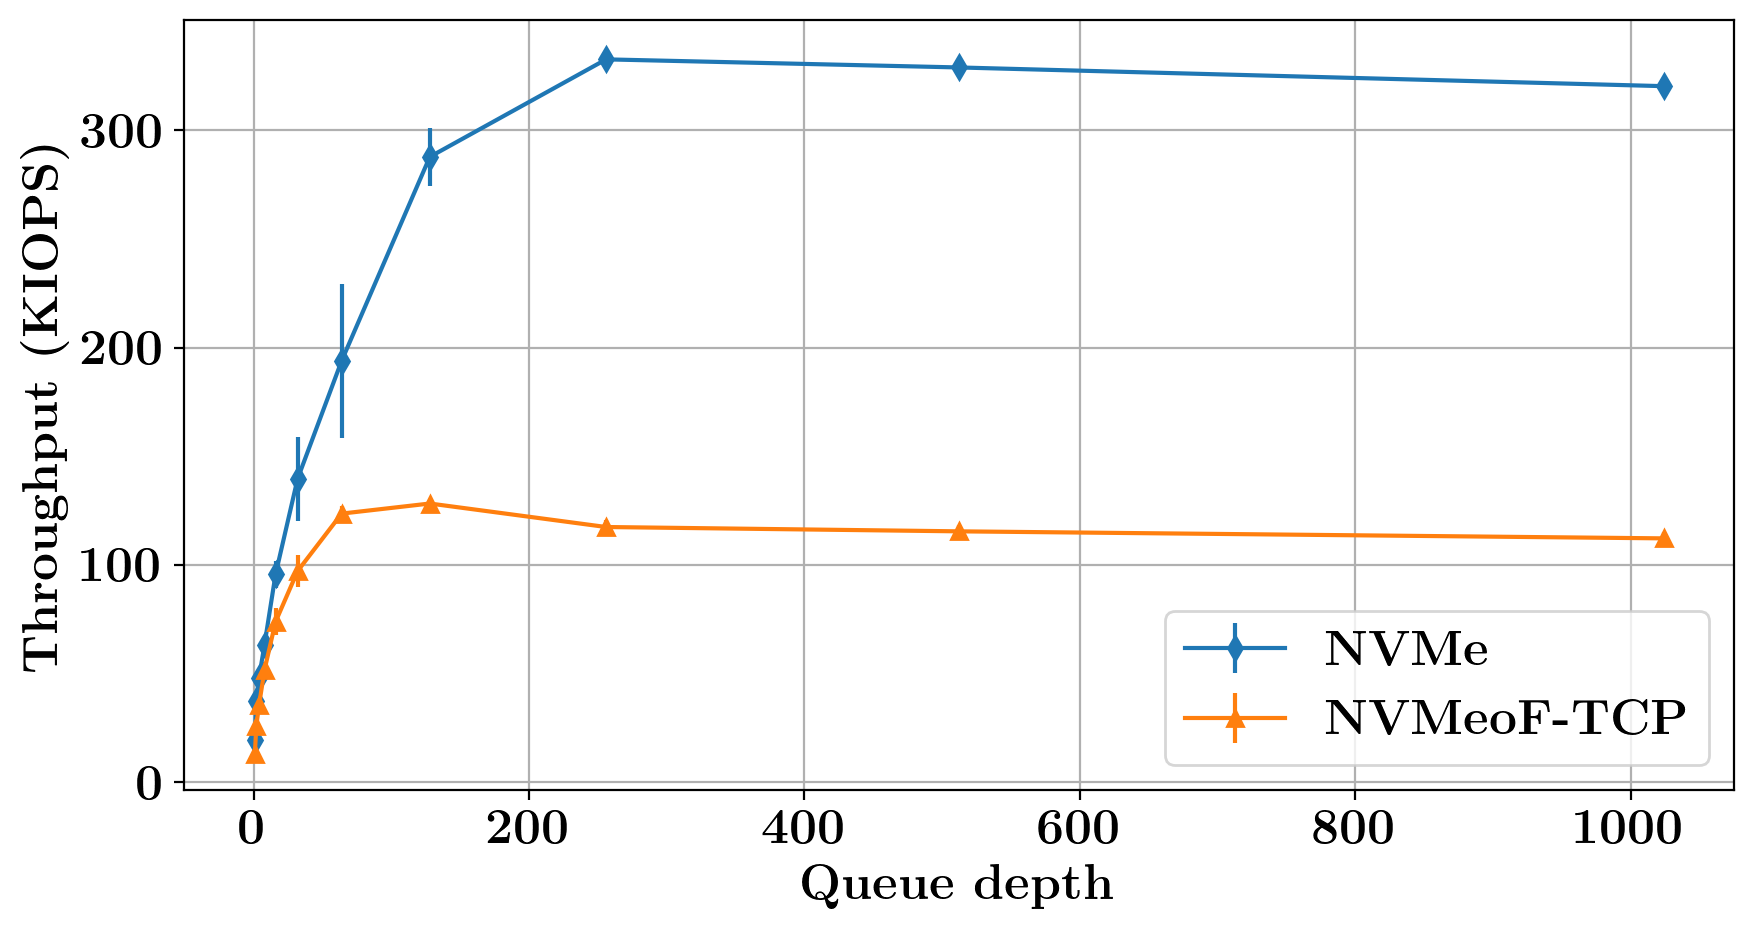

In [6]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
#labels = ["No polling","Polling block","Polling NVMeoF-TCP"]
#for en, j in enumerate(["perf_npoll_iou","perf_npoll_ioup","perf_poll_ioup"]):
labels = [r"\textbf{NVMe}",r"\textbf{NVMeoF-TCP}"]
for en, j in enumerate(["local","remote"]):
    experiments=[]
    for i in [1, 2, 4, 8, 16 ,32, 64, 128, 256, 512, 1024]:
        experiments.append("{}_bench_ioup_SSD_randread_QD{}_P1_4k".format(j, i))
    plot_iops_line(experiments, [1, 2, 4, 8, 16 ,32, 64, 128, 256, 512, 1024], labels[en])

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('Context switch count for different completion semantics (random read on NVMeoF-TCP)')
plt.xlabel(r"\textbf{Queue depth}")
plt.ylabel(r"\textbf{Throughput (KIOPS)}")
plt.legend()
#plt.annotate(r'\textbf{QD128}', xy =(128,128.24), xytext =(50, 50),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
#plt.annotate(r'\textbf{QD256}', xy =(256,332.68), xytext =(200, 250),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
#save_plot("local_remote_iops")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
CALLS=0
scatter_label = {}
for i in [1, 2, 3, 4, 5]:
    names = []
    experiments = []
    for j in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        experiments.append("local_bench_ioup_SSD_randread_QD{}_P{}_4k".format(j, i))
        names.append("QD{}".format(j))
    d = plot_lat_iops(experiments,99.0,names)
    lat = []
    iops = []
    for k in d.keys():
        lat.append(d[k][0])
        iops.append(d[k][1])
        scatter_label[(d[k][1], d[k][0])] = k
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot(iops, lat, '-'+mark, label="{}P".format(i))
    print(d)
    #plt.scatter(iops, lat, marker=mark)

plt.xlabel(r"\textbf{Throughput (KIOPS)}")
plt.ylabel(r'\textbf{p99 Latency($\mu$S)}')
#plt.title("IOPS vs latency for different number of processes (random read on NVMe)")
plt.legend(title=r"\textbf{\# Process}")
plt.annotate(r'\textbf{QD 256}', xy =(332.6887375, 1089.536), xytext =(200, 2000),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
plt.annotate(r'\textbf{QD 64}', xy =(452.61517573199995, 1204.224), xytext =(300, 4000),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
plt.grid(True)
#arrowprops = dict(facecolor ='green', shrink = 0.05),
save_plot("local_remote_lsat")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
CALLS=0
scatter_label = {}
all_vals = []
for i in [1, 2, 3, 4, 5]:
    names = []
    experiments = []
    for j in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        experiments.append("remote_bench_ioup_SSD_randread_QD{}_P{}_4k".format(j, i))
        names.append("QD{}".format(j))
    d = plot_lat_iops(experiments,99.0,names)
    all_vals.append(d)
    lat = []
    iops = []
    for k in d.keys():
        lat.append(d[k][0])
        iops.append(d[k][1])
        scatter_label[(d[k][1], d[k][0])] = k
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot(iops, lat, '-'+mark, label="{}P".format(i))
    print(d)
    #plt.scatter(iops, lat, marker=mark)

plt.xlabel(r"\textbf{Throughput (KIOPS)}")
plt.ylabel(r'\textbf{p99 Latency($\mu$S)}')
#plt.title("IOPS vs latency for different number of processes (random read on NVMeoF-TCP)")
#plt.legend()
plt.annotate(r'\textbf{QD128}', xy =(all_vals[0]["QD128"][1],all_vals[0]["QD128"][0]), xytext =(0, 1300),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
plt.annotate(r'\textbf{QD128}', xy =(all_vals[4]["QD128"][1],all_vals[4]["QD128"][0]), xytext =(250, 4000),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
plt.grid(True)
save_plot("local_remote_rsat")

local_bench_ioup_SSD_randread_QD128_P1_4k 1302050.758333
local_bench_ioup_SSD_randread_QD128_P1_8k 979843.341667
local_bench_ioup_SSD_randread_QD128_P1_16k 1399552.45
local_bench_ioup_SSD_randread_QD128_P1_32k 1670728.433333
local_bench_ioup_SSD_randread_QD128_P1_64k 1779440.8625
local_bench_ioup_SSD_randread_QD128_P1_128k 1421566.070833
remote_bench_ioup_SSD_randread_QD128_P1_4k 512976.058333
remote_bench_ioup_SSD_randread_QD128_P1_8k 871228.358333
remote_bench_ioup_SSD_randread_QD128_P1_16k 1380540.083682
remote_bench_ioup_SSD_randread_QD128_P1_32k 1539787.095833
remote_bench_ioup_SSD_randread_QD128_P1_64k 1778893.116667
remote_bench_ioup_SSD_randread_QD128_P1_128k 1420640.1875


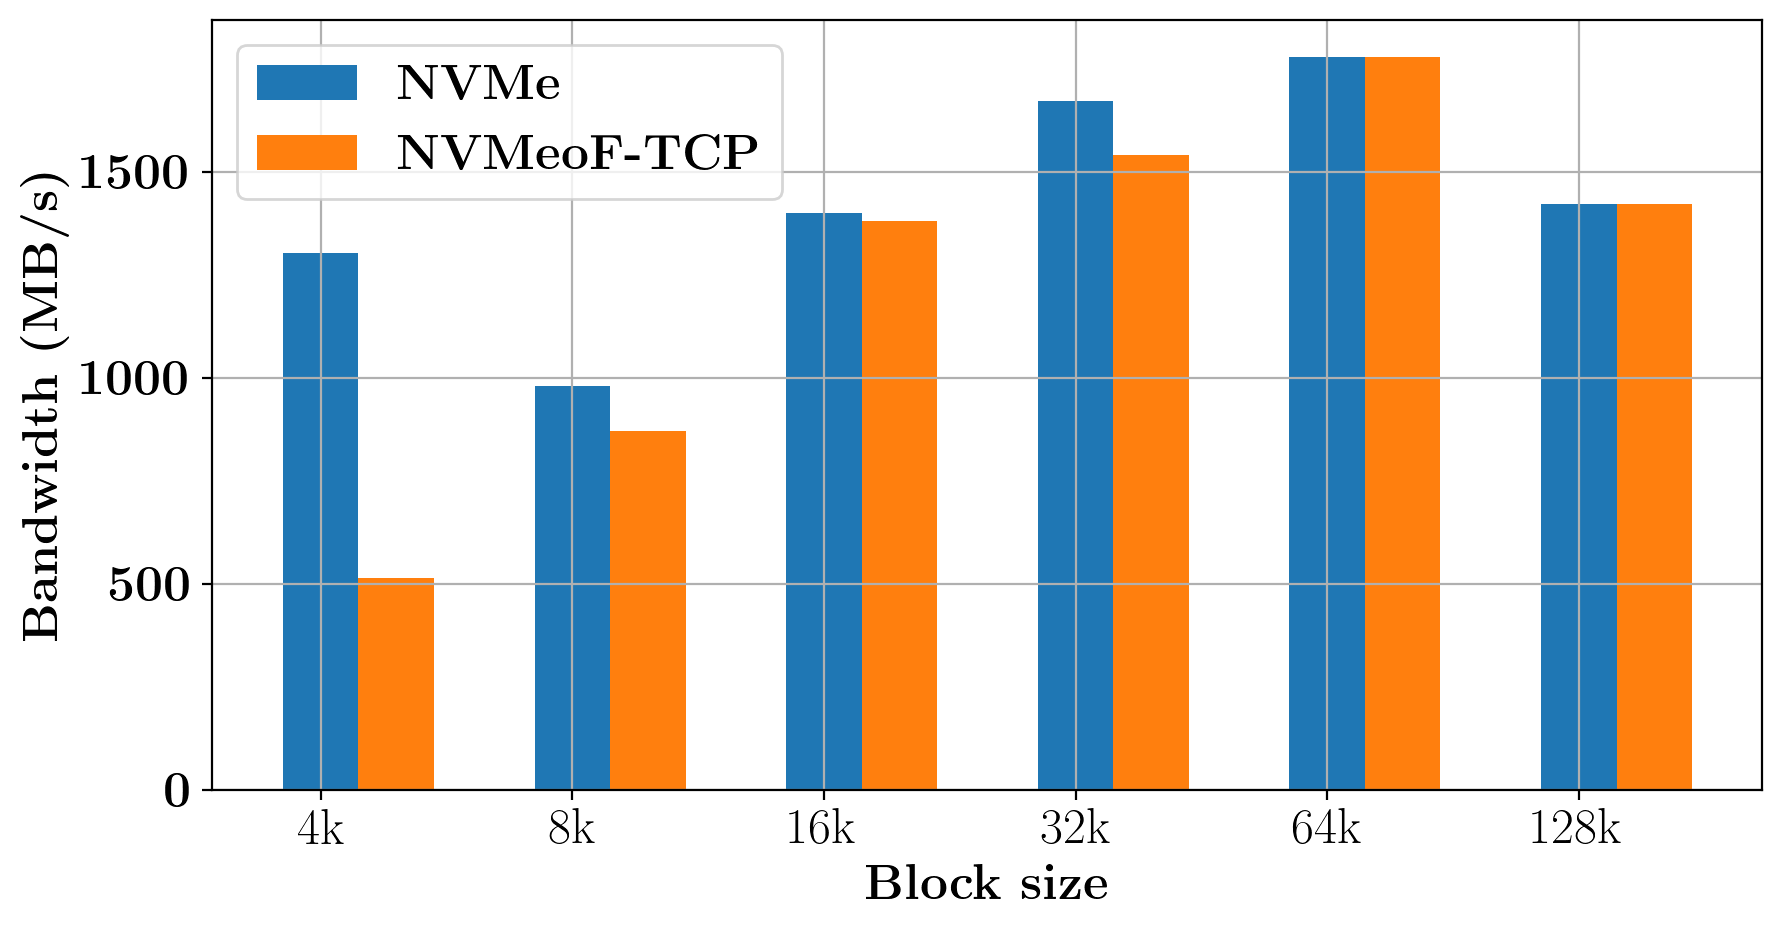

In [11]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
offset = 0
labels=[r"\textbf{NVMe}",r"\textbf{NVMeoF-TCP}"]
for l,i in enumerate(zip(["local","remote"],[128, 128])):
    experiments = []
    for p in ["4k","8k","16k","32k","64k","128k"]:
        experiments.append("{}_bench_ioup_SSD_randread_QD{}_P1_{}".format(i[0],i[1],p))
    plot_bw_bar(experiments,labels[l],offset)
    offset = 0.3
#plt.title("Bandwidth for different block size (random read on NVMeoF-TCP)")
plt.legend()
plt.xlabel(r"\textbf{Block size}")
plt.xticks([i for i in range(6)],["4k","8k","16k","32k","64k","128k"])
save_plot("local_remote_bw")

<h1>RQ3</h1>

<h4>What am I trying to say at the end from this section?</h4> <br>
A: I'm trying quantify what is the effect of interference on L-app while sharing a resource with T-app/B-app.



{'QD1': [104.96, 13.049175], 'QD2': [125.44, 25.6144125], 'QD4': [199.68, 35.414104167], 'QD8': [276.48, 51.686820833], 'QD16': [382.976, 73.78762083299999], 'QD32': [489.472, 97.136575], 'QD64': [651.264, 123.597420833], 'QD128': [1253.376, 128.243833333], 'QD256': [3522.56, 117.427125]}
{'QD1': [115.2, 21.884924685999998], 'QD2': [144.384, 42.537091667], 'QD4': [214.016, 63.50665], 'QD8': [301.056, 99.422502092], 'QD16': [440.32, 154.509744369], 'QD32': [585.728, 197.38228750000002], 'QD64': [741.376, 237.91870578799998], 'QD128': [1253.376, 249.5298125], 'QD256': [3620.864, 227.381828905]}
{'QD1': [130.56, 30.981817573], 'QD2': [152.576, 59.618654167], 'QD4': [224.256, 91.408175], 'QD8': [317.44, 143.561107444], 'QD16': [505.856, 217.684638424], 'QD32': [684.032, 279.863038215], 'QD64': [864.256, 326.959410042], 'QD128': [1548.288, 340.380004167], 'QD256': [3588.096, 325.977021165]}
{'QD1': [138.24, 39.691541876], 'QD2': [185.344, 72.335429707], 'QD4': [234.496, 111.3265625], 'QD8':

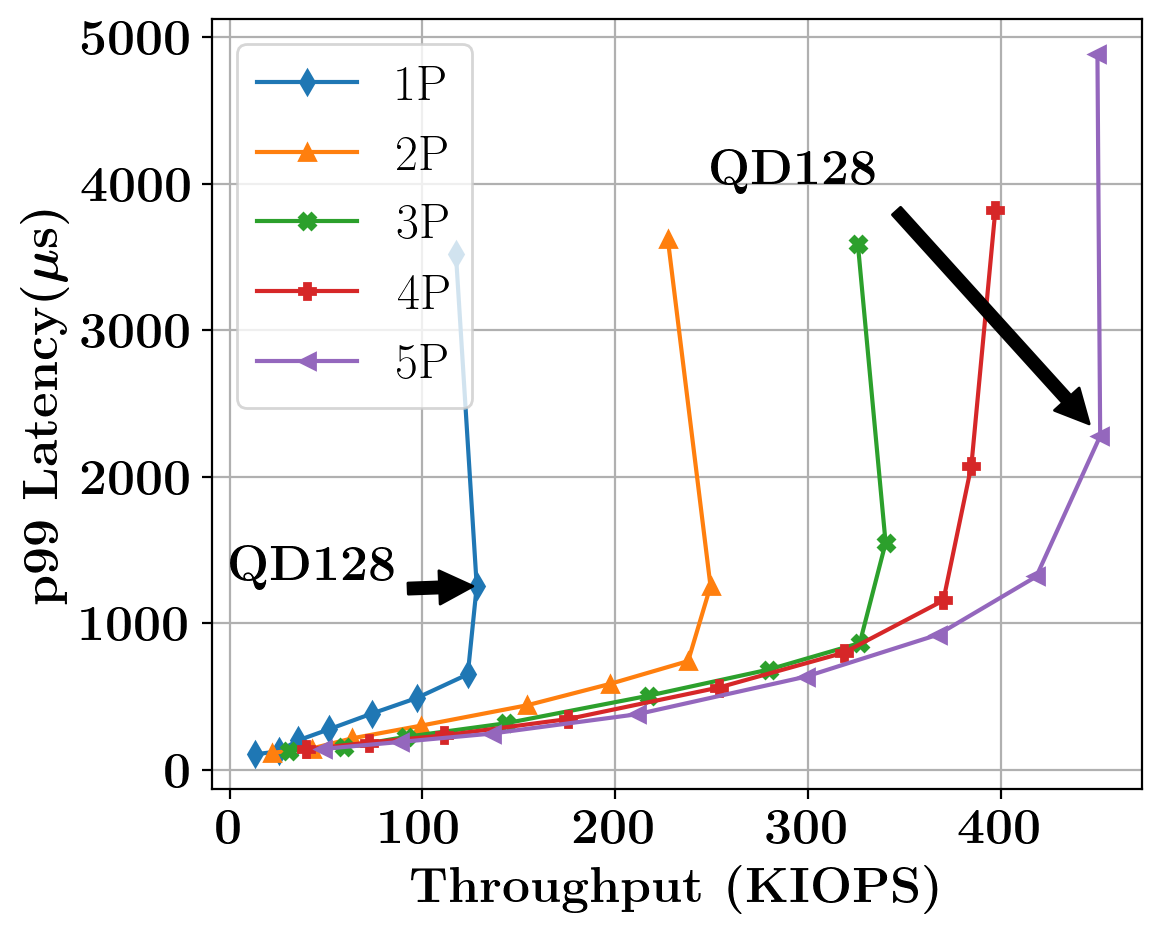

In [12]:
#Saturation (Initiator, SSD)
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
CALLS=0
scatter_label = {}
all_vals = []
for i in [1, 2, 3, 4, 5]:
    names = []
    experiments = []
    for j in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        experiments.append("remote_bench_ioup_SSD_randread_QD{}_P{}_4k".format(j, i))
        names.append("QD{}".format(j))
    d = plot_lat_iops(experiments,99.0,names)
    all_vals.append(d)
    lat = []
    iops = []
    for k in d.keys():
        lat.append(d[k][0])
        iops.append(d[k][1])
        scatter_label[(d[k][1], d[k][0])] = k
    mark = MARKERS[CALLS]
    CALLS = (CALLS + 1)%len(MARKERS)
    plt.plot(iops, lat, '-'+mark, label="{}P".format(i))
    print(d)
    #plt.scatter(iops, lat, marker=mark)

plt.xlabel(r"\textbf{Throughput (KIOPS)}")
plt.ylabel(r'\textbf{p99 Latency($\mu$s)}')
#plt.title("IOPS vs latency for different number of processes (random read on NVMeoF-TCP)")
#plt.legend()
plt.annotate(r'\textbf{QD128}', xy =(all_vals[0]["QD128"][1],all_vals[0]["QD128"][0]), xytext =(0, 1300),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
plt.annotate(r'\textbf{QD128}', xy =(all_vals[4]["QD128"][1],all_vals[4]["QD128"][0]), xytext =(250, 4000),arrowprops = dict(facecolor ='black', shrink = 0.05)) 
plt.grid(True)
plt.legend()
save_plot("remote_IS_sat")

remote_target_C1_ioup_SSD_randread_QD128_P1_4k 126.020205021
remote_target_C1_ioup_SSD_randread_QD128_P2_4k 180.30469456100002
remote_target_C1_ioup_SSD_randread_QD128_P3_4k 180.557606363
remote_target_C1_ioup_SSD_randread_QD128_P4_4k 178.878306311


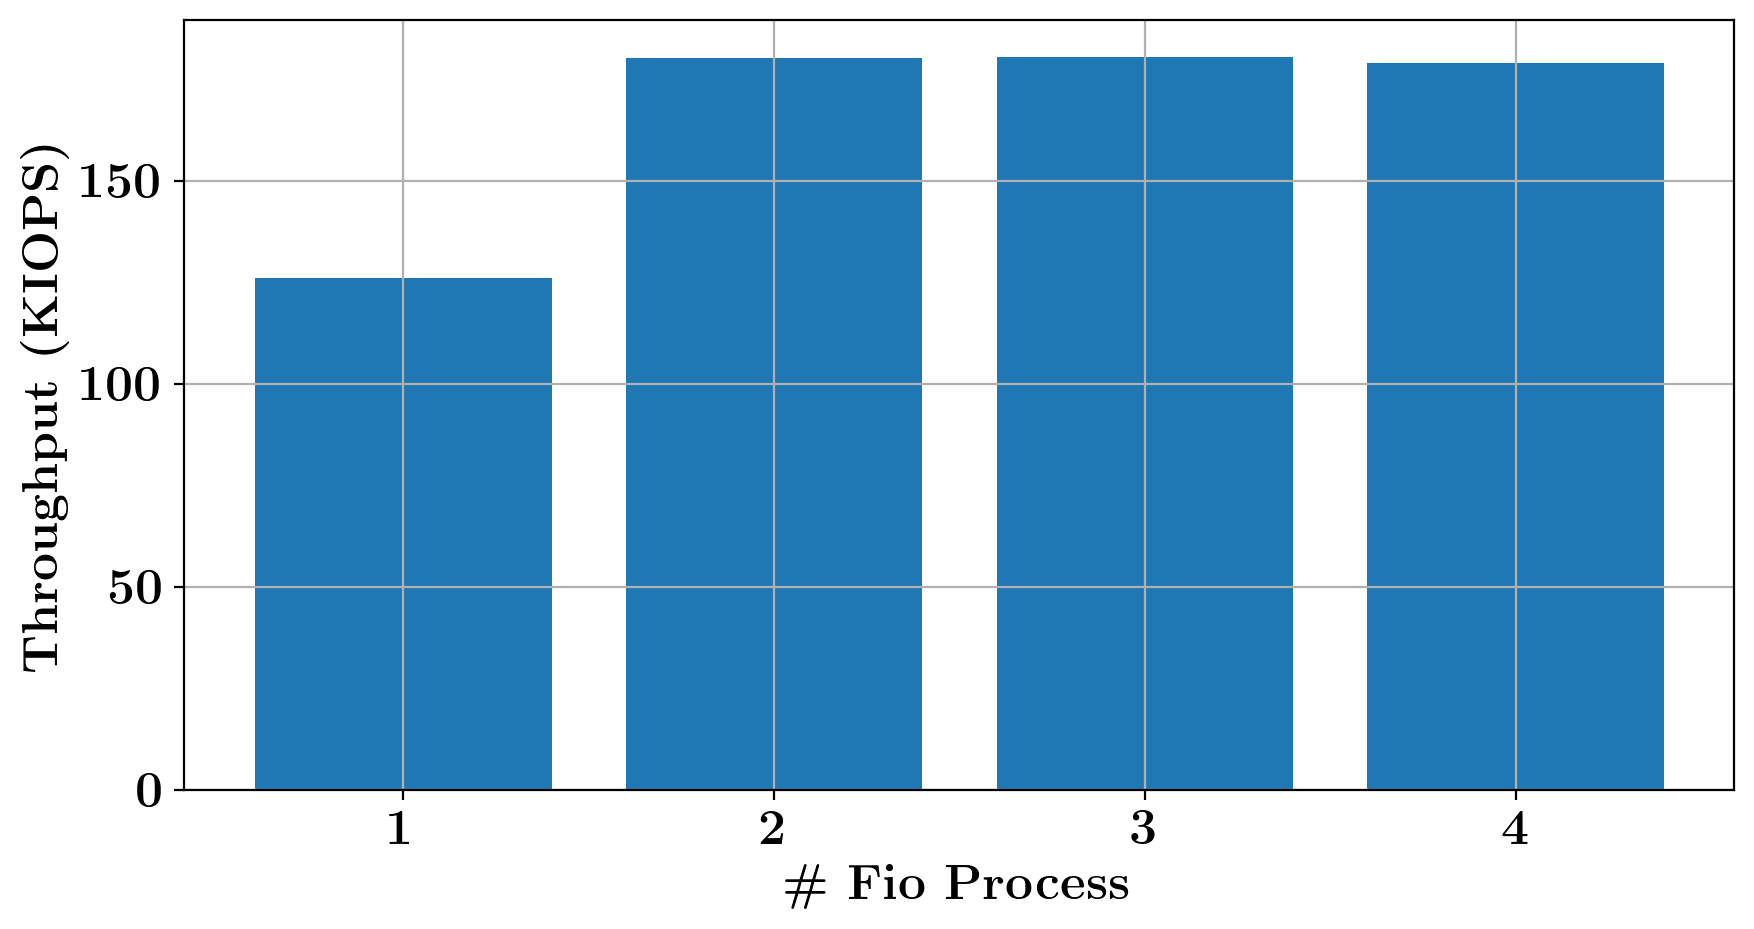

In [20]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
CALLS=0
experiments = []
for j in [1,2,3,4]: #,"npoll_ioup","poll_ioup": #,
    experiments.append("remote_target_C1_ioup_SSD_randread_QD128_P{}_4k".format(j))
plot_iops_bar(experiments,[1,2,3,4])

#plt.plot(PROCESS, [434 for i in PROCESS],color='black')
#plt.title('IOPS for different number of queue pairs (random read on NVMeoF-TCP)')
plt.xlabel(r"\textbf{\# Fio Process}")
plt.ylabel(r'\textbf{Throughput (KIOPS)}')
plt.xticks([1,2,3,4])
plt.ylim(bottom=0)
save_plot("remote_target_sat")
#plt.legend()

In [4]:
f = open("./qos2/crunched_numbers_qos.json")
op = json.load(f)

In [1]:
#For each resource (Initiator and Target):
    #L-app deviation for load
    #T-app deviation for load

#LOAD 10,20,30,40,50..100

#Latency -> Latency interference
    #Initiator -> Redo without polling
    #Target -> We see a gradual increase in latency! 


#Throughput -> Throughput sustained
    #Initiator -> Redo without polling

In [5]:
TARGET_MAX_IOPS=180
INITIATOR_MAX_IOPS=128
SSD_MAX_IOPS=460
def get_back_iops(exp):
    d = op[exp]['iops']
    return d

Label :  [10, 20, 30, 40, 50, 60, 70, 80]
[10, 20, 30, 40, 50, 60, 70, 80] [2.394202898550725, 1.8608695652173914, 2.0541062801932366, 2.5855072463768116, 2.933333333333334, 3.196135265700484, 4.672463768115943, 6.886956521739131]


Text(0, 0.5, '\\textbf{Latency Interference}')

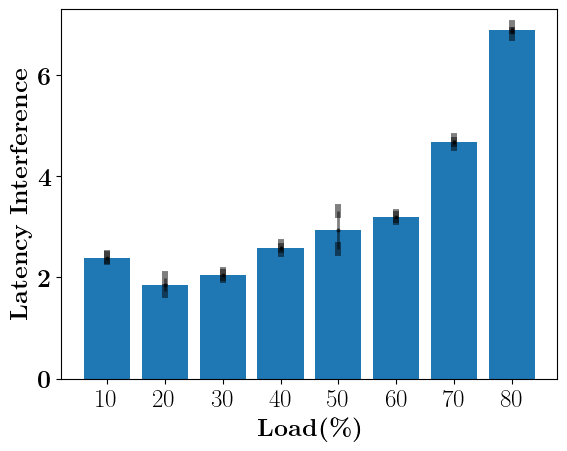

In [6]:
"""
Target core sharing latency
"""
import math
import numpy as np


def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def get_latency(exp):
    d = op[exp]['latency']['percentile']
    d = {float(k): float(v)/10**3 for k, v in d.items()}
    return d[99.00]

def get_lat_std(exp):
    d = op[exp]['latency']['latency']['percentile']
    d = {float(k): float(v)/10**3 for k, v in d.items()}
    return d[99.00]

fig, ax = plt.subplots()
base="remote_ID_TS_SD_split_bread_fread_SSD_QD1_LOAD0_latency"
exp="remote_ID_TS_SD_split_bread_fread_SSD_QD1_LOAD{}_P{}_{}"
label=[]
load=[10,20,30,40,50,60,70,80]
harvest = []
resource = [2]

#Modify the label according the exp load
for k,i in enumerate(load):
    flag = False
    ld = 0
    for j in resource:
        #We will have load, and background IOPS
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        #print(biops, ((i - 2)/100)*TARGET_MAX_IOPS)
        #print(biops, ((i)/100)*TARGET_MAX_IOPS)
        if(biops <= ((i)/100)*TARGET_MAX_IOPS):
            flag = True
            if ((biops/TARGET_MAX_IOPS)*100 > ld):
                ld = (biops/TARGET_MAX_IOPS)*100
        elif flag:
            flag = False

    if flag:
        if (len(label)>0) and (label[-1]+5 > ld):
            break
        if ld:
            #If greater than prev quantam
            label.append(int(ld))
    else:
        label.append(i)

print("Label : ", label)



for j in resource:
    #harvest.append([])
    harvest = []
    stds = []
    for k,i in enumerate(load):
        if(k >= len(label)):
            break
        ch = exp.format(i,j,"latency")
        lat2 = get_latency(ch) 
        lat1 = get_latency(base)
        lat2_std = get_lat_std(exp.format(i,j,"std_dev"))/lat1
        val = lat2/lat1
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        if(biops < (((label[k])/100)*TARGET_MAX_IOPS)):
            val = 0
        harvest.append(val)
        stds.append(lat2_std)

print(label, harvest)
plt.bar([str(i) for i in label], harvest)
plt.errorbar([str(i) for i in label], harvest,stds,fmt='.',elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2,color="black")

plt.xlabel(r"\textbf{Load(\%)}")
plt.ylabel(r"\textbf{Latency Interference}")
#save_plot("interf_target_lat")

[10, 20, 30, 40, 50, 60]
[0.9757629040456615, 0.9541588603467375, 0.9288941178561247, 0.9052660235858825, 0.7510279450998223, 0.6064727135751057] [0.018551648693315943, 0.008361194748792348, 0.03562272994741376, 0.00125474038575204, 0.0014973580439749893, 0.0011942599272823993]


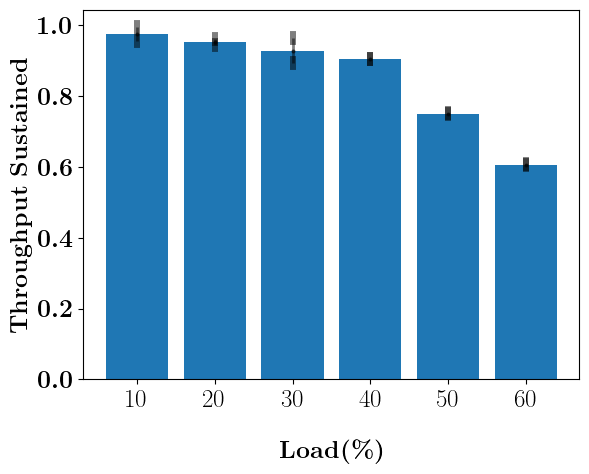

In [7]:
"""
Target sharing throughput interference
"""
import math
import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def get_iops(exp):
    d = op[exp]['iops']['mean']
    return d
def get_iops_std(exp):
    d = op[exp]['latency']['iops']['mean']
    return d

fig, ax = plt.subplots()
base="remote_ID_TS_SD_split_bread_fread_SSD_QD128_LOAD0_latency"
exp="remote_ID_TS_SD_split_bread_fread_SSD_QD128_LOAD{}_P{}_{}"
label=[]
load=[10,20,30,40,50,60]
harvest = []
stds=[]
resource = [2]

#Modify the label according the exp load
for k,i in enumerate(load):
    flag = False
    ld = 0
    for j in resource:
        #We will have load, and background IOPS
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        #print(biops, ((i - 2)/100)*TARGET_MAX_IOPS)
        if(biops <= ((i)/100)*TARGET_MAX_IOPS):
            flag = True
            if ((biops/TARGET_MAX_IOPS)*100 > ld):
                ld = (biops/TARGET_MAX_IOPS)*100
        elif flag:
            flag = False

    if flag:
        if (len(label)>0) and (label[-1]+5 > ld):
            break
        if ld:
            #If greater than prev quantam
            label.append(int(ld))
        
    else:
        label.append(i)        

print(label)


for j in resource:
    for k,i in enumerate(load):
        if k==len(label):
            break
        ch = exp.format(i, j, "latency")
        std = exp.format(i,j,"std_dev")
        iops2 = get_iops(ch) 
        iops2_std = get_iops_std(std)
        iops1 = get_iops(base)
        
        val = iops2/iops1 #(Base - Load)/Base
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        if(biops < (((label[k])/100)*TARGET_MAX_IOPS)):
            val = 0
        harvest.append(val)
        stds.append(iops2_std/iops1)

#harvest = np.array(harvest)
#print(harvest)
#harvest = harvest/np.linalg.norm(harvest)
#print(harvest)
# im, cbar = heatmap(harvest, resource, label, ax=ax,
#                    cmap="Blues", cbarlabel=r"\textbf{Mean throughput interference}")
# texts = annotate_heatmap(im, valfmt="{x:.2f}")

# fig.tight_layout()
print(harvest,stds)
plt.bar([str(i) for i in label], harvest)
plt.errorbar([str(i) for i in label], harvest,stds,fmt='.',elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2,color="black")

plt.xlabel(r"\textbf{Load(\%)}", labelpad=20)
#plt.gca().xaxis.set_label_coords(0.5, 1.2) 
plt.ylabel(r"\textbf{Throughput Sustained}")
#plt.gca().yaxis.set_label_coords(-0.1, 0.5)
plt.grid(False)
#save_plot("interf_target_iops")

Label :  [10, 20, 30, 40]
[10, 20, 30, 40] [37.99546191247974, 38.11993517017828, 38.36888168557536, 37.74651539708265]


Text(0, 0.5, '\\textbf{Latency Interference}')

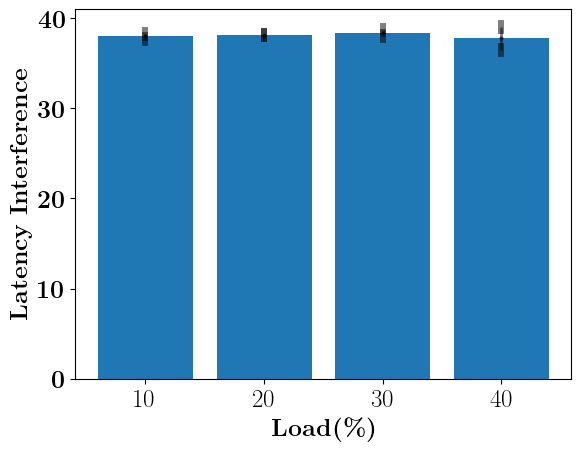

In [7]:
"""
Initiator core sharing latency polling
"""
import math
import numpy as np


def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def get_latency(exp):
    d = op[exp]['latency']['percentile']
    d = {float(k): float(v)/10**3 for k, v in d.items()}
    return d[99.00]

def get_lat_std(exp):
    d = op[exp]['latency']['latency']['percentile']
    d = {float(k): float(v)/10**3 for k, v in d.items()}
    return d[99.00]

fig, ax = plt.subplots()
base="remote_ICS_TD_SD_baseline_bread_fread_SSD_QD1_LOAD0_latency"
exp="remote_ICS_TD_SD_baseline_bread_fread_SSD_QD1_LOAD{}_P{}_{}"
label=[]
load=[10,20,30,40]
harvest = []
resource = [1]

#Modify the label according the exp load
for k,i in enumerate(load):
    flag = False
    ld = 0
    for j in resource:
        #We will have load, and background IOPS
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        #print(biops, ((i - 2)/100)*TARGET_MAX_IOPS)
        #print(biops, ((i)/100)*TARGET_MAX_IOPS)
        if(biops <= ((i)/100)*INITIATOR_MAX_IOPS):
            flag = True
            if ((biops/INITIATOR_MAX_IOPS)*100 > ld):
                ld = (biops/INITIATOR_MAX_IOPS)*100
        elif flag:
            flag = False

    if flag:
        if (len(label)>0) and (label[-1]+5 > ld):
            break
        if ld:
            #If greater than prev quantam
            label.append(int(ld))
    else:
        label.append(i)

print("Label : ", label)



for j in resource:
    #harvest.append([])
    harvest = []
    stds = []
    for k,i in enumerate(load):
        if(k >= len(label)):
            break
        ch = exp.format(i,j,"latency")
        lat2 = get_latency(ch) 
        lat1 = get_latency(base)
        lat2_std = get_lat_std(exp.format(i,j,"std_dev"))/lat1
        val = lat2/lat1
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        if(biops < (((label[k])/100)*INITIATOR_MAX_IOPS)):
            val = 0
        harvest.append(val)
        stds.append(lat2_std)

print(label, harvest)
plt.bar([str(i) for i in label], harvest)
plt.errorbar([str(i) for i in label], harvest,stds,fmt='.',elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2,color="black")

plt.xlabel(r"\textbf{Load(\%)}")
plt.ylabel(r"\textbf{Latency Interference}")
#save_plot("interf_target_lat")

[10, 20, 30, 40]
remote_ICS_TD_SD_baseline_bread_fread_SSD_QD1_LOAD10_P1_throughput
remote_ICS_TD_SD_baseline_bread_fread_SSD_QD1_LOAD20_P1_throughput
remote_ICS_TD_SD_baseline_bread_fread_SSD_QD1_LOAD30_P1_throughput
remote_ICS_TD_SD_baseline_bread_fread_SSD_QD1_LOAD40_P1_throughput
forground [49.27226339999999, 48.6209238, 47.2963422, 45.4830604]
background [49.271258, 48.622090199999995, 47.296088, 45.48425759999999]
[]


(0.0, 70.0)

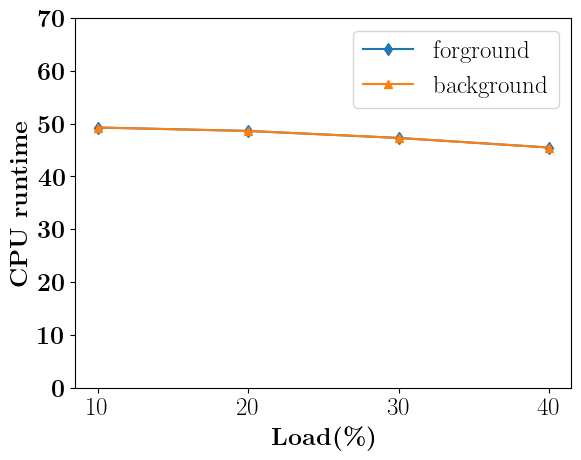

In [9]:
"""
Intiator core sharing latency
"""
import math
import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def get_latency(exp):
    d = op[exp]['latency']['percentile']
    d = {float(k): float(v)/10**3 for k, v in d.items()}
    return d[99.00]

fig, ax = plt.subplots()
base="remote_ICS_TD_SD_nopoll_bread_fread_SSD_QD1_LOAD0_latency"
exp="remote_ICS_TD_SD_baseline_bread_fread_SSD_QD1_LOAD{}_P{}_{}"
label=[]
load=[10,20,30,40]
harvest = []
resource = [1]

#Modify the label according the exp load
for k,i in enumerate(load):
    flag = False
    ld = 0
    for j in resource:
        #We will have load, and background IOPS
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        #print(biops, ((i - 2)/100)*TARGET_MAX_IOPS)
        if(biops <= ((i)/100)*INITIATOR_MAX_IOPS):
            flag = True
            if ((biops/INITIATOR_MAX_IOPS)*100 > ld):
                ld = (biops/INITIATOR_MAX_IOPS)*100
        elif flag:
            flag = False

    if flag:
        if (len(label)>0) and (label[-1]+5 > ld):
            break
        if ld:
            #If greater than prev quantam
            label.append(int(ld))
    else:
        label.append(i)

print(label)
for j in resource:
    exp1 = [] 
    exp2 = []
    for k,i in enumerate(load):
        if(k >= len(label)):
            break
        ch = exp.format(i,j,"latency")
        exp1.append(ch)
        bflow = exp.format(i,j,"throughput")
        print(bflow)
        exp2.append(bflow)

plot_cpu(exp1,label,"forground")
plot_cpu(exp2,label,"background")


#harvest = np.array(harvest)
#print(harvest)
#harvest = harvest/np.linalg.norm(harvest)
#print(harvest)
# im, cbar = heatmap(harvest, resource, label, ax=ax,
#                    cmap="Blues", cbarlabel=r"\textbf{p99 Latency interference}")
# texts = annotate_heatmap(im, valfmt="{x:.2f}")

# fig.tight_layout()
print(harvest)
#plt.bar([str(i) for i in label], harvest)
#plt.plot(label, harvest,"-o")
plt.xlabel(r"\textbf{Load(\%)}")
#plt.gca().xaxis.set_label_coords(0.5, 1.2) 
plt.ylabel(r"\textbf{CPU runtime}")
#plt.gca().yaxis.set_label_coords(-0.1, 0.5)
plt.grid(False)
plt.legend()
plt.ylim(0,70)

[10, 20, 30, 40]
[0.4798243277010726, 0.49246177009601094, 0.5029006875109817, 0.49690335890582654] [0.007031124829562561, 0.003817083083953057, 0.004692202673706571, 0.004367581721210502]


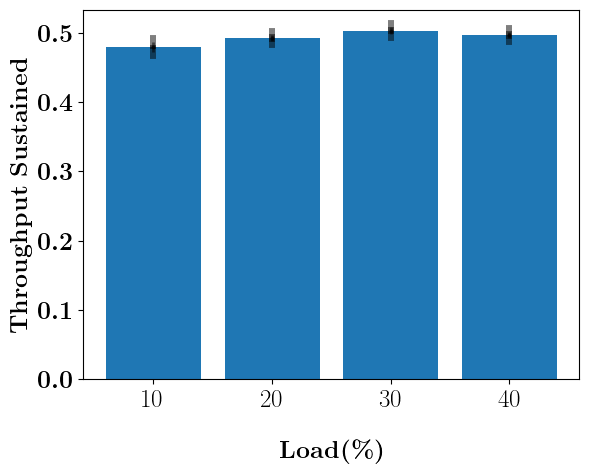

In [10]:
"""
Target sharing throughput interference
"""
import math
import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def get_iops(exp):
    d = op[exp]['iops']['mean']
    return d
def get_iops_std(exp):
    d = op[exp]['latency']['iops']['mean']
    return d

fig, ax = plt.subplots()
base="remote_ICS_TD_SD_baseline_bread_fread_SSD_QD128_LOAD0_latency"
exp="remote_ICS_TD_SD_baseline_bread_fread_SSD_QD128_LOAD{}_P{}_{}"
label=[]
load=[10,20,30,40]
harvest = []
stds=[]
resource = [1]

#Modify the label according the exp load
for k,i in enumerate(load):
    flag = False
    ld = 0
    for j in resource:
        #We will have load, and background IOPS
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        #print(biops, ((i - 2)/100)*TARGET_MAX_IOPS)
        if(biops <= ((i)/100)*INITIATOR_MAX_IOPS):
            flag = True
            if ((biops/INITIATOR_MAX_IOPS)*100 > ld):
                ld = (biops/INITIATOR_MAX_IOPS)*100
        elif flag:
            flag = False

    if flag:
        if (len(label)>0) and (label[-1]+5 > ld):
            break
        if ld:
            #If greater than prev quantam
            label.append(int(ld))
        
    else:
        label.append(i)        

print(label)


for j in resource:
    for k,i in enumerate(load):
        if k==len(label):
            break
        ch = exp.format(i, j, "latency")
        std = exp.format(i,j,"std_dev")
        iops2 = get_iops(ch) 
        iops2_std = get_iops_std(std)
        iops1 = get_iops(base)
        
        val = iops2/iops1 #(Base - Load)/Base
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        if(biops < (((label[k])/100)*INITIATOR_MAX_IOPS)):
            val = 0
        harvest.append(val)
        stds.append(iops2_std/iops1)

#harvest = np.array(harvest)
#print(harvest)
#harvest = harvest/np.linalg.norm(harvest)
#print(harvest)
# im, cbar = heatmap(harvest, resource, label, ax=ax,
#                    cmap="Blues", cbarlabel=r"\textbf{Mean throughput interference}")
# texts = annotate_heatmap(im, valfmt="{x:.2f}")

# fig.tight_layout()
print(harvest,stds)
plt.bar([str(i) for i in label], harvest)
plt.errorbar([str(i) for i in label], harvest,stds,fmt='.',elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2,color="black")

plt.xlabel(r"\textbf{Load(\%)}", labelpad=20)
#plt.gca().xaxis.set_label_coords(0.5, 1.2) 
plt.ylabel(r"\textbf{Throughput Sustained}")
#plt.gca().yaxis.set_label_coords(-0.1, 0.5)
plt.grid(False)
#save_plot("interf_target_iops")

[10, 20, 30, 40]
[0.7254657314675025, 0.7300056691720657, 0.6735375863852169, 0.5947757852794141]


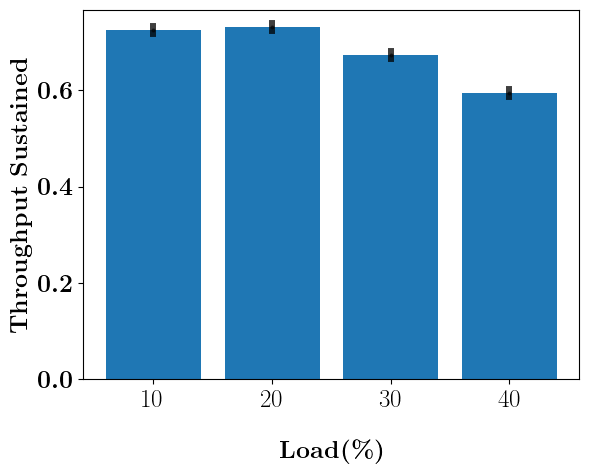

In [16]:
"""
Target sharing throughput interference
"""
import math
import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def get_iops(exp):
    d = op[exp]['iops']['mean']
    return d
def get_iops_std(exp):
    d = op[exp]['latency']['iops']['mean']
    return d

fig, ax = plt.subplots()
base="remote_ICS_TD_SD_baseline_bread_fread_SSD_QD128_LOAD0_latency"
exp="remote_ICS_TD_SD_nopoll_bread_fread_SSD_QD128_LOAD{}_P{}_{}"
label=[]
load=[10,20,30,40]
harvest = []
stds=[]
resource = [1]

#Modify the label according the exp load
for k,i in enumerate(load):
    flag = False
    ld = 0
    for j in resource:
        #We will have load, and background IOPS
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        #print(biops, ((i - 2)/100)*TARGET_MAX_IOPS)
        if(biops <= ((i)/100)*INITIATOR_MAX_IOPS):
            flag = True
            if ((biops/INITIATOR_MAX_IOPS)*100 > ld):
                ld = (biops/INITIATOR_MAX_IOPS)*100
        elif flag:
            flag = False

    if flag:
        if (len(label)>0) and (label[-1]+5 > ld):
            break
        if ld:
            #If greater than prev quantam
            label.append(int(ld))
        
    else:
        label.append(i)        

print(label)


for j in resource:
    for k,i in enumerate(load):
        if k==len(label):
            break
        ch = exp.format(i, j, "latency")
        std = exp.format(i,j,"std_dev")
        iops2 = get_iops(ch) 
        iops2_std = get_iops_std(std)
        iops1 = get_iops(base)
        
        val = iops2/iops1 #(Base - Load)/Base
        bflow = exp.format(i,j,"throughput")
        biops = get_back_iops(bflow)/1000
        if(biops < (((label[k])/100)*INITIATOR_MAX_IOPS)):
            val = 0
        harvest.append(val)
        stds.append(iops2_std/iops1)

#harvest = np.array(harvest)
#print(harvest)
#harvest = harvest/np.linalg.norm(harvest)
#print(harvest)
# im, cbar = heatmap(harvest, resource, label, ax=ax,
#                    cmap="Blues", cbarlabel=r"\textbf{Mean throughput interference}")
# texts = annotate_heatmap(im, valfmt="{x:.2f}")

# fig.tight_layout()
print(harvest)
plt.bar([str(i) for i in label], harvest)
plt.errorbar([str(i) for i in label], harvest,stds,fmt='.',elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2,color="black")

plt.xlabel(r"\textbf{Load(\%)}", labelpad=20)
#plt.gca().xaxis.set_label_coords(0.5, 1.2) 
plt.ylabel(r"\textbf{Throughput Sustained}")
#plt.gca().yaxis.set_label_coords(-0.1, 0.5)
plt.grid(False)
#save_plot("interf_target_iops")